In [1]:
# 라이브러리

import pandas as pd ; pd.options.display.float_format = '{:.2f}'.format # 소수 둘째자리까지 표시
import numpy as np
import math

import time
from time import sleep
import random
import datetime
from datetime import datetime, timedelta, datetime
import json

from string import ascii_lowercase

import collections
from dateutil.relativedelta import relativedelta

from powernad.API.Campaign import *
from powernad.API.RelKwdStat import *

from urllib.error import HTTPError
import urllib.request

from bs4 import BeautifulSoup ; import bs4
from selenium import webdriver
import psycopg2
import re

from tqdm.notebook import tqdm

import requests; from urllib.parse import urlparse
import seaborn as sns; sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2) ; sns.set_color_codes()

import matplotlib; import matplotlib.pyplot as plt

import squarify


# 네트워크 시각화용
import warnings
warnings.filterwarnings(action='ignore')

# from matplotlib import font_manager, rc
# from matplotlib import style
# style.use('ggplot')
# %matplotlib inline


# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf", size=20).get_name()
# rc('font', family=font_name)
# plt.rcParams['axes.unicode_minus'] = False

# 구간날짜 변수 생성

In [2]:
"""
날짜 구간 정보가 들어있는 변수들을 생성합니다.
이 변수들을 활용해 날짜 구간을 기준으로 매일 데이터를 갱신합니다.
...
----------------------------------
today = 현재
today = 오늘자 년월일 문자열
yesterday = 어제 
time_week = 7일 전
time_month = 1개월 전
time_year = 1년 전
time_two_years = 2년 전
time_three_years = 3년 전
"날짜구간 변수명"_index = 날짜구간 인덱스
dt_"날짜구간" = 날짜구간 인덱스를 리스트 형태로 
"""

# 오늘
toda = datetime.now()
today = str(datetime.now().date()) # 


# 1일 전
yesterday = toda - relativedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')
yesterday = str(yesterday)


# 1주
time_week = toda - relativedelta(weeks=1)
time_week = time_week.strftime('%Y-%m-%d')
time_week = str(time_week)
# 최근 1주 리스트
week_index = pd.date_range(start=time_week, end= yesterday)
dt_week = week_index.strftime("%Y-%m-%d").tolist()


# 1개월
time_month = toda - relativedelta(months=1)
time_month = time_month.strftime('%Y-%m-%d')
time_month= str(time_month)
# 최근 1개월 리스트
month_index = pd.date_range(start=time_month, end= yesterday)
dt_month = month_index.strftime("%Y-%m-%d").tolist()


# 1년
time_year = toda - relativedelta(years=1)
time_year = time_year.strftime('%Y-%m-%d')
time_year= str(time_year)
# 최근 1년 리스트
year_index = pd.date_range(start=time_year, end= yesterday)
dt_year = year_index.strftime("%Y-%m-%d").tolist()


# 2년
time_two_years = toda - relativedelta(years=2)
time_two_years = time_two_years.strftime('%Y-%m-%d')
time_two_years = str(time_two_years)
# 최근 2년 리스트
two_years_index = pd.date_range(start=time_two_years, end= yesterday)
dt_two_years = two_years_index.strftime("%Y-%m-%d").tolist()

# 3년
time_three_years = toda - relativedelta(years=3)
time_three_years = time_three_years.strftime('%Y-%m-%d')
time_three_years = str(time_three_years)
# 최근 3년 리스트
three_years_index = pd.date_range(start=time_three_years, end= yesterday)
dt_three_years = three_years_index.strftime("%Y-%m-%d").tolist()

In [3]:
# df_origin
"""
네이버 데이터랩 쇼핑인사이트 기준 일자별 패션의류 카테고리 검색랭킹 500위에 포함된 키워드 정보가 있는 데이터프레임입니다.
데이터 시작일 = 2017-08-01
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""
df_origin = pd.read_csv('C:/project/CODE/keyword/data/furniture/naver_top_500/' + yesterday + '_data.csv', header = None, encoding='utf-8', index_col=0)
df_origin.columns = ['rank', 'keyword', 'year', 'month', 'day', 'ymd']
df_origin = df_origin.sort_values(by=['ymd', 'rank'])
df_origin = df_origin.reset_index(drop=True)
df_origin

,rank,keyword,year,month,day,ymd
0,1,화장대,2017,8,1,2017-08-01
1,2,책상,2017,8,1,2017-08-01
2,3,쇼파,2017,8,1,2017-08-01
3,4,침대,2017,8,1,2017-08-01
4,5,책장,2017,8,1,2017-08-01
...,...,...,...,...,...,...
773841,495,벽걸이led시계,2022,6,12,2022-06-12
773842,496,소파패드,2022,6,12,2022-06-12
773843,497,창문가리개,2022,6,12,2022-06-12
773844,499,양면암막커튼,2022,6,12,2022-06-12


In [4]:
# df
"""
개별 키워드들의 날짜 정보가 가장 오래된(키워드가 최초 랭크인한 날) 행을 1개만 남기고 나머지 중복값을 모두 삭제한 데이터프레임입니다.
기존에 검색어 랭킹 500위 이내에 없던 키워드가 최초로 랭크된 것은 순간적으로 해당 키워드에 대한 관심도가 증가했다고 볼 수 있습니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df = df_origin.drop_duplicates(['keyword'], keep='first')
df = df.reset_index(drop=True)
df

,rank,keyword,year,month,day,ymd
0,1,화장대,2017,8,1,2017-08-01
1,2,책상,2017,8,1,2017-08-01
2,3,쇼파,2017,8,1,2017-08-01
3,4,침대,2017,8,1,2017-08-01
4,5,책장,2017,8,1,2017-08-01
...,...,...,...,...,...,...
5824,489,거실화장실극세사발매트,2022,6,11,2022-06-11
5825,87,시스템신발장모자,2022,6,12,2022-06-12
5826,93,접이식침대4단각도조절,2022,6,12,2022-06-12
5827,410,시스템선반,2022,6,12,2022-06-12


In [5]:
# df_monthly_keywords
"""
최초등장일이 최근 1개월 이내인 키워드들만 보여주는 데이터프레임입니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df_monthly_keywords = df.query('ymd == @dt_month')
df_monthly_keywords = df_monthly_keywords.reset_index(drop=True)
df_monthly_keywords 

,rank,keyword,year,month,day,ymd
0,72,실내용디퓨저byldf001천연디퓨저,2022,5,13,2022-05-13
1,74,천연디퓨저실내용디퓨저byldf001,2022,5,13,2022-05-13
2,75,헤링본여름쿨매트,2022,5,13,2022-05-13
3,83,천연디퓨저디퓨저byldf001실내용,2022,5,13,2022-05-13
4,84,실내용byldf001천연디퓨저디퓨저,2022,5,13,2022-05-13
...,...,...,...,...,...,...
312,489,거실화장실극세사발매트,2022,6,11,2022-06-11
313,87,시스템신발장모자,2022,6,12,2022-06-12
314,93,접이식침대4단각도조절,2022,6,12,2022-06-12
315,410,시스템선반,2022,6,12,2022-06-12


In [6]:
# lis
"""
최초등장일이 최근 1개월 이내인 키워드들이 담긴 리스트를 생성합니다.
"""
lis = list(df_monthly_keywords['keyword'])
len(lis)

317

# 키워드 검색량 조회용 네이버 API

In [7]:
# Naver API 조회용 기본 설정
"""
네이버 광고 API 정보를 조회하기 위한 변수입니다.
...
BASE_URL = 네이버 API 주소
API_KEY = 네이버 검색광고 API 엑세스 라이선스
SECRET_KEY = 네이버 검색광고 API SECRET
CUSTOMER_ID = 네이버 검색광고 API ID
rel = 클라이언트 정보 저장 변수
"""

BASE_URL = 'https://api.naver.com'
API_KEY = '01000000000fcd1ce283f84b5b3f32330368ac6dce35c5a8e3feabf4cfec31ae32b7e9d0e8'
SECRET_KEY = 'AQAAAAAPzRzig/hLWz8yMwNorG3OPks1JGYBp40Ib+rqqydacA=='
CUSTOMER_ID = '2488417'
rel = RelKwdStat(BASE_URL, API_KEY, SECRET_KEY, CUSTOMER_ID)

In [8]:
# search_keyword
def search_keyword(searchword):
    """
    네이버 API 키워드 월간 검색수를 반환해주는 함수입니다.
    ...
    searchword = API 정보를 조회할 키워드명
    """
    
    # kwdDataList = 키워드 검색 정보를 담은 변수입니다.
    kwdDataList = rel.get_rel_kwd_stat_list(siteId=None, biztpId=None, hintKeywords=searchword, event=None, month=None, showDetail='1')

    # kwd_result
    
    '''
    kwdDataList[0].relKeyword = 키워드
    kwdDataList[0].monthlyPcQcCnt = 월간 검색수 (PC)
    kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (Mobile)
    kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (total)
    '''
    kwd_result = (kwdDataList[0].relKeyword,
                 kwdDataList[0].monthlyPcQcCnt,
                 kwdDataList[0].monthlyMobileQcCnt,
                 kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt)
    
    # kwd_result[3] = 검색한 키워드명과 월간 pc, 모바일, 총 검색수를 반환합니다
    return(kwd_result[3])

# 네이버 데이터랩 (검색어트렌드) 클라이언트 정보
'''
client_id = 네이버 데이터랩 (검색어트렌드) id
client_secret = 네이버 데이터랩 (검색어트렌드) secret
'''
client_id = "IZr05hqQauLB_l9gJEFG"  
client_secret = "cARLdhpO5W"  

In [9]:
# 키워드별 검색량 저장용 자료구조 생성
'''
dictionary_yester = 전일 키워드 검색량 / 딕셔너리
dictionary_now = 오늘자 키워드 검색량  / 딕셔너리
error = 에러 확인 / 리스트
df_total = 일자별 키워드 검색량 / 데이터프레임
'''
dictionary_yester={}
dictionary_now={}
error=[]
df_total = pd.DataFrame(columns=['키워드', '날짜', '수집날짜', '검색량'])


In [10]:
# serach_query
def search_query(list_name):
    """
    위에서 선언한 search_keyword() 함수를 통해 각 키워드의 월간 총 검색량을 추출한 후, 
    날짜별 검색량으로 전환한 데이터프레임을 생성하는 함수입니다.
    ...
    list_name = 조회하고 싶은 키워드 정보가 들어있는 리스트 이름
    """
    
    global df_total
    for i in tqdm(list_name):  
        print(i)
        sleep(1)
        try:
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)


                url = "https://openapi.naver.com/v1/datalab/search"
                body = "{\"startDate\":\""+time_month+"\",\"endDate\":\""+today+"\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\""+i+"\",\"keywords\":[\""+i+"\"]}]}";
                requested = urllib.request.Request(url)
                requested.add_header("X-Naver-Client-Id", client_id)
                requested.add_header("X-Naver-Client-Secret", client_secret)
                requested.add_header("Content-Type", "application/json")
                response = urllib.request.urlopen(requested, data=body.encode("utf-8"))
                rescode = response.getcode()

                if(rescode==200):
                    response_body = response.read()
                    output_data = response_body.decode('utf-8')
                else:
                    print('Error code:'+ rescode)
                    pass

                # result = API 조회 결과값이 들어있는 변수입니다.
                result = json.loads(output_data)

                # date = a['period'] 에서 최근 1개월간의 날짜 값들을 추출한 리스트를 생성합니다.
                date = [a['period'] for a in result['results'][0]['data']]

                # aa = 날짜와 날짜별 검색량을 추출한 데이터프레임을 생성합니다.
                aa = pd.DataFrame({'date':date, 
                              'querycount':[a['ratio'] for a in result['results'][0]['data']],
                              })

                # 일일 데이터 계산 
                sleep(0.5)
                total = aa['querycount'].sum() 
                
                # 30일간 모든 백분율 값을 더한 후 일자별 실제 검색량을 반환합니다.
                '''
                total = 날짜별 모든 백분율 검색량을 더한 값
                float(a) = 월간 총 검색량 실수화
                x = 각 일자별 검색량
                '''
                aa['검색량'] = aa['querycount'].apply(lambda x :((x / total)*float(a)))


            else : 
                pass

        except (TypeError, IndexError,KeyError,ValueError):
            print(" 타입 or 인덱스 에러,Value 에러:",i)
            error.append(i)
            pass


        except HTTPError:
            print('http 에러:', i )
            error.append(i)
            pass

            #여기부터 새로 코딩
        try: 
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        


                date = pd.DataFrame(data=dt_month, columns=['날짜'])

                spred = pd.merge(date,aa,left_on='날짜',right_on='date',how='outer')
                spred.drop(['date'],inplace=True, axis=1)

                spred.replace(np.nan,0,inplace=True)


                a=[] 

                for j in range(len(spred)) : 
                    a.append(today)


                spred['수집날짜'] = a
                spred['키워드'] = i
                spred = spred[['키워드', '날짜','수집날짜', '검색량']]

                if i in dictionary_yester:

                    pass

                else : 
                    dictionary_yester[i]=[]



                dictionary_now[i]=spred
                df_total = pd.concat([df_total, spred])

            else:
                pass

        except (TypeError, IndexError,KeyError,ValueError):

            pass

        sleep(0.5)
        try :
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        

                if dictionary_yester[i]==[]:
                    dictionary_yester[i] = dictionary_now[i]

                else : 
                    pass 
            else:
                pass


        except (TypeError, IndexError,KeyError):
              pass


        except ValueError:


                yester_df= dictionary_yester[i]
                today_df = dictionary_now[i]


                yester_df.set_index('날짜',inplace=True)

                today_df.set_index('날짜',inplace=True)

                yester_df.update(today_df)


                tmpt = today_df.iloc[-1,:]

                yester_df = yester_df.append(tmpt)

                yester_df.reset_index(inplace=True)
                today_df.reset_index(inplace=True)


                dictionary_yester[i] = yester_df


        except :
            print('API 에러',i)
            error.append(i)



        sleep(3)

    df_total['검색량'] = df_total['검색량'].astype(int)
    
    df_total.to_csv('C:/project/CODE/keyword/data/furniture/query/' + yesterday + '_month_furniture_query_by_date.csv', encoding='UTF-8')
    
    return(df_total)

In [11]:
search_query(lis)

  0%|          | 0/317 [00:00<?, ?it/s]

실내용디퓨저byldf001천연디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용디퓨저byldf001천연디퓨저
천연디퓨저실내용디퓨저byldf001
 타입 or 인덱스 에러,Value 에러: 천연디퓨저실내용디퓨저byldf001
헤링본여름쿨매트
 타입 or 인덱스 에러,Value 에러: 헤링본여름쿨매트
천연디퓨저디퓨저byldf001실내용
 타입 or 인덱스 에러,Value 에러: 천연디퓨저디퓨저byldf001실내용
실내용byldf001천연디퓨저디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용byldf001천연디퓨저디퓨저
천연디퓨저디퓨저실내용byldf001
 타입 or 인덱스 에러,Value 에러: 천연디퓨저디퓨저실내용byldf001
실내용byldf001디퓨저천연디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용byldf001디퓨저천연디퓨저
실내용천연디퓨저byldf001디퓨저
 타입 or 인덱스 에러,Value 에러: 실내용천연디퓨저byldf001디퓨저
쪽가위
실내용천연디퓨저디퓨저byldf001
마켓비원목선반
 타입 or 인덱스 에러,Value 에러: 마켓비원목선반
소음재
모래멍
책상컴퓨터의자
양면암막커튼
학생책상의자
메트로캔들워머
 타입 or 인덱스 에러,Value 에러: 메트로캔들워머
릴리4인용세라믹식탁
컴퓨터학생의자
빨아쓰는발매트
헬시메이트블랙라벨기능성메모리폼경추베개
오에스퍼니처osg100컴퓨터게이밍의자
 타입 or 인덱스 에러,Value 에러: 오에스퍼니처osg100컴퓨터게이밍의자
원목4인식탁세트벤치+의자형
 타입 or 인덱스 에러,Value 에러: 원목4인식탁세트벤치+의자형
장미맨숀
전자렌지밥솥오븐수납장선반
 타입 or 인덱스 에러,Value 에러: 전자렌지밥솥오븐수납장선반
전자레인지밥솥오븐선반수납장600
 타입 or 인덱스 에러,Value 에러: 전자레인지밥솥오븐선반수납장600
사무용책상의자
실내용디퓨저
실내용천연디퓨저
무볼트앵글
모던티비다이
데코지오쉐도우아일렛형암막커튼일반커튼방한커튼가리개커튼
 타입 or 인덱스 에러,Value 에러: 데

,키워드,날짜,수집날짜,검색량
0,쪽가위,2022-05-13,2022-06-13,125
1,쪽가위,2022-05-14,2022-06-13,113
2,쪽가위,2022-05-15,2022-06-13,119
3,쪽가위,2022-05-16,2022-06-13,146
4,쪽가위,2022-05-17,2022-06-13,177
...,...,...,...,...
26,친환경종이가구,2022-06-08,2022-06-13,0
27,친환경종이가구,2022-06-09,2022-06-13,0
28,친환경종이가구,2022-06-10,2022-06-13,0
29,친환경종이가구,2022-06-11,2022-06-13,3434


In [12]:
# df_query
"""
네이버 패션의류 탑 500 에 신규진입한 키워드의 최근 1개월 동안의 일자별 검색량이 있는 데이터프레임입니다.
"""
df_query = df_total
df_query = df_query[['키워드', '날짜', '수집날짜', '검색량']]
df_query = df_query.rename(columns={'키워드':'keyword', '날짜':'ymd', '수집날짜':'search_date', '검색량': 'query'})
df_query['query'] = df_query['query'].astype(int)
df_query

,keyword,ymd,search_date,query
0,쪽가위,2022-05-13,2022-06-13,125
1,쪽가위,2022-05-14,2022-06-13,113
2,쪽가위,2022-05-15,2022-06-13,119
3,쪽가위,2022-05-16,2022-06-13,146
4,쪽가위,2022-05-17,2022-06-13,177
...,...,...,...,...
26,친환경종이가구,2022-06-08,2022-06-13,0
27,친환경종이가구,2022-06-09,2022-06-13,0
28,친환경종이가구,2022-06-10,2022-06-13,0
29,친환경종이가구,2022-06-11,2022-06-13,3434


In [13]:
# df_query_sum
"""
신규키워드들의 최근 1개월 누적 검색량이 있는 데이터프레임입니다.
"""
df_query_sum = df_query[['keyword', 'query']].groupby('keyword').sum()
df_query_sum = df_query_sum.rename(columns = {'query':'query_month'})
df_query_sum.sort_values('query_month', ascending=False)

,query_month
keyword,
장미맨숀,223885
지컷원피스,52875
린넨,49776
화사거울,38865
에몬스,33465
...,...
핑크발매트,58
리모컨달무드등,49
소음재,49


In [14]:
# df_query_m
"""
최근 1개월 이내에 키워드 검색 탑 500에 등장한 키워드들의 검색량을 보여주는 데이터프레임입니다.
...
query = 신규 키워드 랭크 진입 당일 검색량
query_month = 신규 키워드의 최근 1개월 누적 검색량
"""

df_query_m = pd.merge(df_monthly_keywords, df_query, on='keyword')
df_query_m = pd.merge(df_query_m, df_query_sum, on = 'keyword')
df_query_m = df_query_m[df_query_m['ymd_x'] == df_query_m['ymd_y']]
df_query_m = df_query_m.drop(['ymd_y'], axis=1).sort_values(['ymd_x', 'rank'])
df_query_m.rename(columns = {'ymd_x':'ymd'},inplace=True)
df_query_m.reset_index(inplace=True, drop=True)

df_query_m

,rank,keyword,year,month,day,ymd,search_date,query,query_month
0,144,쪽가위,2022,5,13,2022-05-13,2022-06-13,125,4476
1,281,소음재,2022,5,13,2022-05-13,2022-06-13,16,49
2,309,모래멍,2022,5,13,2022-05-13,2022-06-13,440,11156
3,388,책상컴퓨터의자,2022,5,13,2022-05-13,2022-06-13,407,8606
4,434,양면암막커튼,2022,5,13,2022-05-13,2022-06-13,48,474
...,...,...,...,...,...,...,...,...,...
158,327,거실장2000,2022,6,11,2022-06-11,2022-06-13,559,4088
159,402,천연라텍스베개,2022,6,11,2022-06-11,2022-06-13,341,4708
160,452,침대옆협탁,2022,6,11,2022-06-11,2022-06-13,423,5894
161,410,시스템선반,2022,6,12,2022-06-12,2022-06-13,234,6254


In [15]:
# df_m
"""
최근 1개월 이내 키워드 검색 탑 500 에 등장한 키워드 정보가 담겨있는 데이터프레임입니다.
*********************** 최종적으로 스트림릿에 추가해야하는 데이터프레임 *************************
"""
df_m = pd.DataFrame({'등장일자':df_query_m['ymd'], '랭킹':df_query_m['rank'], '키워드':df_query_m['keyword'], '일간검색량':df_query_m['query'], '월간검색량':df_query_m['query_month']})
df_m = df_m.sort_values('등장일자', ascending=False)
df_m.to_csv('C:/project/CODE/keyword/data/furniture/output/' + yesterday + '_trendy_furniture_keywords.csv', encoding='UTF-8')
df_m.head(50)


,등장일자,랭킹,키워드,일간검색량,월간검색량
162,2022-06-12,461,친환경종이가구,3145,6579
161,2022-06-12,410,시스템선반,234,6254
160,2022-06-11,452,침대옆협탁,423,5894
159,2022-06-11,402,천연라텍스베개,341,4708
158,2022-06-11,327,거실장2000,559,4088
152,2022-06-10,269,이동식철제행거,95,1696
147,2022-06-10,53,티비거실장,336,4695
148,2022-06-10,92,다용도4단서랍장,132,766
149,2022-06-10,194,고무나무식탁,29,837
150,2022-06-10,204,시스템수납선반,296,1056


In [16]:
df_m_list = list(df_m['키워드'])

In [17]:
# keyword_grouping

splitted_list = [['소파']] # splitted_list = 기준 키워드
def keyword_grouping(list_name):
    """
    키워드의 장기간 검색량을 일자별로 수집하는 함수입니다.
    네이버 API는 한번에 5개까지만 키워드를 조회할 수 있는데, 한 번에 5개 이상의 키워드 검색량 정보를 조회합니다.
    단, 네이버 API 를 통해 최근 1개월보다 이전의 검색량을 조회할 경우, 
    검색된 키워드의 검색량이 아니라 조회한 키워드 중 검색량이 가장 많았던 시점을 기준으로 0 ~ 100 사이의 백분율 정보를 제공합니다.
    각 키워드의 실제 검색량이 달라도 같은 100으로 집계되는 경우를 방지하기 위해 5개의 그룹에 항상 포함되는 기준 키워드를 설정했습니다.
    ex)
    ['소파', 'A', 'B', 'C', 'D']
    ['소파', 'E', 'F', 'G', 'H']
    ...
    list_name = 조회할 키워드가 들어있는 리스트명
    """

    # 키워드가 5개씩 순차적으로 들어있는 2차원 리스트 생성 반복문
    # 마지막 리스트가 5개로 떨어지지 않을 경우 '더미' 를 채워서 5개를 완성합니다.
    for i in range(0, len(list_name), 4):
        y = []
        if i <= len(list_name) - 4:
            y = [list_name[i], list_name[i+1], list_name[i+2], list_name[i+3]]
            splitted_list.append(y)
        elif i == len(list_name) - 3:
            y = [list_name[i], list_name[i+1], list_name[i+2], '더미']
            splitted_list.append(y)
        elif i == len(list_name) - 2:
            y = [list_name[i], list_name[i+1], '더미', '더미']
            splitted_list.append(y)
        else:
            y = [list_name[i], '더미', '더미', '더미']
            splitted_list.append(y)  

    i = 1
    
    return splitted_list

In [18]:
keyword_grouping(df_m_list)

[['소파'],
 ['친환경종이가구', '시스템선반', '침대옆협탁', '천연라텍스베개'],
 ['거실장2000', '이동식철제행거', '티비거실장', '다용도4단서랍장'],
 ['고무나무식탁', '시스템수납선반', '아쿠아텍스4인용소파', '세라믹거실테이블'],
 ['대리석거실테이블', '원목2인식탁세트', '이태리세라믹식탁세트', '마켓비책상'],
 ['패브릭스툴', '야외이동주방', '네이즌쿨매트', '초등학생바른자세책상'],
 ['원목티비다이거실장', '접이식토퍼매트리스', '코지블', '모찌'],
 ['순면양면누빔베개커버', '네이즌여름매트', '호텔식암막커튼나비주름', '박술녀인견이불'],
 ['아쿠아텍스모듈소파', '박구환', '침대슈퍼싱글', '메쉬사무용의자'],
 ['침대프레임퀸', '아이스냉쿨매트', '도토리수납함', '식탁4인용'],
 ['쇼파3인', '소파아쿠아텍스', '책상원목', '쇼파4인'],
 ['식탁6인용', '식탁세트4인용', '루나매트리스', '실리콘네온사인'],
 ['소파3인용', '화사초', '식탁세라믹', '침대프레임원목'],
 ['김광규카페트', '화사거울', '로보어린이의자', '꼬메벨로메모리폼접이식침대토퍼매트오가닉매쉬ss'],
 ['마켓비슬라이딩옷장', '꼬메벨로접이식바닥메모리폼토퍼매트리스10cms', '셀레티거울', '에피하임에그체어안락의자'],
 ['밥솥선반', '에피하임거실안락의자', '박술녀풍기인견이불', '슈퍼싱글메모리폼'],
 ['덴마크화병', '린넨', '사무용파티션', '에몬스'],
 ['인조', '지컷원피스', '유치원', '인홈저상형침대'],
 ['르올여름이불', '책상의자사무용', '디자인누비호텔식암막커튼', '더리체세라믹식탁'],
 ['꾸며드림숙면베개', '조야패브릭2인소파', '암막커튼추천', '대리석소파테이블'],
 ['황금', '한옥', '사계절암막커튼', '사무실컴퓨터의자'],
 ['메탈시트지', '초마루디퓨저', '스타벅스테이블', '스피드랙행거'],
 ['침대커튼', '티비다이거실장'

In [29]:
# datalab_api
def datalab_api(keywords):
    """
    네이버 데이터랩 API를 활용해 입력된 키워드의 최근 3년간 일자별 검색량을 조회하는 함수입니다.
    ...
    list_name = 검색량을 조회하고자 하는 키워드
    """
    
    # 데이터랩 API 계정 및 url 정보
    client_id = "kJG1RgASjzoPJ2bpUq8L"    
    client_secret = "LBYXkCdlRf"
    url = "https://openapi.naver.com/v1/datalab/search"
    
    # 조회 조건 설정
    '''
    startdate = 검색량 조회 시작일자
    enddate = 검색량 조회 종료일자
    timeunit = 검색량 수집 기준
    keywordgroups = 조회를 원하는 키워드 그룹
    '''
    body = {
        "startDate":time_three_years,
        "endDate":yesterday,
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]},
            {"groupName":str(keywords[2]),"keywords":[str(keywords[2])]},
            {"groupName":str(keywords[3]),"keywords":[str(keywords[3])]},
            {"groupName":str(keywords[4]),"keywords":[str(keywords[4])]},
        ],
    }
    
    # 검색량 조회 결과값이 들어있는 딕셔너리 변수
    body = json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 조회한 5개의 키워드 검색량을 각각의 데이터프레임에 저장
    df1 = pd.DataFrame(json_obj['results'][0]['data'])
    df2 = pd.DataFrame(json_obj['results'][1]['data'])
    df3 = pd.DataFrame(json_obj['results'][2]['data'])
    df4 = pd.DataFrame(json_obj['results'][3]['data'])
    df5 = pd.DataFrame(json_obj['results'][4]['data'])

    
    
    # 딕셔너리 안에 조회 결과가 들어있지 않아서 데이터프레임을 생성하지 못할 시 오류가 발생하는 경우를 방지하기 위한 반복문
    # 데이터프레임 생성에 실패한 경우 값이 0으로 채워진 데이터프레임을 생성
    df_list = [df1,df2,df3,df4,df5]
    for i in tqdm(range(len(df_list))):
        if len(list(df_list[i].columns)) ==2:
            df_list[i].columns=['기간', str(keywords[i])]
        elif len(list(df_list[i].columns)) ==0:
            df_list[i]['기간'] = 0
            df_list[i][str(keywords[i])] = 0

    # 5개의 키워드 검색량 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)
    df3 = df2.merge(df3, how='outer', on='기간').fillna(0)
    df4 = df3.merge(df4, how='outer', on='기간').fillna(0)
    df5 = df4.merge(df5, how='outer', on='기간').fillna(0)

    return df5


In [30]:
# df_api
"""
기준 키워드(소파)의 검색량 최소값과 최대값을 구해서 상대치를 갱신하는 정규화입니다.
"""
df_api = datalab_api(splitted_list[0] + splitted_list[1])
a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
print('기준 키워드(소파) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"))

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(소파) 검색량 최소값: 33.20079, 최대값100.00000


In [31]:
# datalab_api_keylist
def datalab_api_keylist(list_name):
    """
    기준 키워드를 기준으로 최소-최대 정규화를 적용한 데이터랩 검색량을 추출하는 함수입니다.
    ...
    list_name = 기준 키워드와 검색량을 조회할 키워드들이 들어있는 2차원 리스트
    """
    
    # df_api
    # 기준 키워드(잠옷)의 검색량 최소값과 최대값을 구하는 정규화 작업으로 키워드별 실제 검색량의 상대치를 보정합니다.
    df_api = datalab_api(list_name[0]+list_name[1])
    a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
    print('기준 키워드(소파) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"), '\n')
    
    i = 2
    while i < len(list_name):
        try:
            df1 = datalab_api(list_name[0]+list_name[i])
            x, y = df1.iloc[:,1].min(), df1.iloc[:,1].max()    
            # df1 = 기준 키워드 검색량의 최소-최대 정규화

            df1.iloc[:,2] = (df1.iloc[:,2] -x) / (y - x) * (b - a) + a
            df1.iloc[:,3] = (df1.iloc[:,3] -x) / (y - x) * (b - a) + a
            df1.iloc[:,4] = (df1.iloc[:,4] -x) / (y - x) * (b - a) + a
            df1.iloc[:,5] = (df1.iloc[:,5] -x) / (y - x) * (b - a) + a
            df1 = df1.drop(columns=['기간', '소파'])
            df_api = pd.concat([df_api, df1], axis=1)

            
            i+=1
        
            time.sleep( random.uniform(2,4) )
        
        except IndexError:
            pass
        
        print('작업 진행률: ' + format(i / len(splitted_list), ".2f"))

    # 더미 키워드 삭제 및 저장
    df_api = df_api[df_api.columns.drop(list(df_api.filter(regex='더미')))]
    df_api.to_csv('C:/project/CODE/keyword/data/furniture/query/' + yesterday + '_three_years_furniture_query.csv', encoding='UTF-8')

    # 
    return df_api

In [32]:
datalab_api_keylist(splitted_list)

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(소파) 검색량 최소값: 33.20079, 최대값100.00000 



  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.07


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.10


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.12


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.14


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.17


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.19


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.21


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.24


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.26


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.29


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.31


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.33


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.36


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.38


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.40


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.43


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.45


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.48


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.50


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.52


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.55


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.57


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.60


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.62


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.64


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.67


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.69


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.71


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.74


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.76


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.79


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.81


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.83


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.86


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.88


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.90


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.93


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.95


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.98


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 1.00


,기간,소파,친환경종이가구,시스템선반,침대옆협탁,천연라텍스베개,거실장2000,이동식철제행거,티비거실장,다용도4단서랍장,...,헬시메이트블랙라벨기능성메모리폼경추베개,빨아쓰는발매트,양면암막커튼,모래멍,책상컴퓨터의자,소음재,학생책상의자,릴리4인용세라믹식탁,컴퓨터학생의자,쪽가위
0,2019-06-13,36.05,0.00,2.54,0.12,0.70,0.17,0.00,1.09,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,2.03
1,2019-06-14,34.78,0.00,2.13,0.00,0.66,0.24,0.00,1.21,0.00,...,0.00,0.09,0.00,0.00,0.00,0.00,0.15,0.00,0.00,1.94
2,2019-06-15,41.57,0.00,2.06,0.15,0.60,0.31,0.00,1.45,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,1.15
3,2019-06-16,47.93,0.00,2.28,0.21,0.78,0.14,0.00,1.70,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.38
4,2019-06-17,43.80,0.00,2.86,0.11,0.84,0.34,0.00,1.76,0.00,...,0.00,0.09,0.00,0.00,0.00,0.00,0.11,0.00,0.00,1.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2022-06-08,48.10,0.00,3.21,3.20,4.16,2.02,1.45,4.08,0.66,...,0.00,0.09,0.00,4.14,5.29,0.00,2.05,0.00,1.51,2.66
1092,2022-06-09,49.06,0.00,2.98,2.39,5.40,1.99,1.42,7.34,1.99,...,0.00,0.08,0.08,4.47,4.97,0.00,1.80,0.00,1.30,2.49
1093,2022-06-10,44.36,0.00,3.20,2.89,5.37,2.66,1.44,5.20,2.06,...,0.00,0.17,0.00,3.73,3.70,0.00,1.53,0.00,1.35,2.40
1094,2022-06-11,53.82,51.98,2.97,6.62,5.26,8.79,1.45,1.90,2.13,...,0.00,0.08,0.00,3.64,3.84,0.00,1.84,0.00,0.96,2.02


# 키워드 검색량 시각화

In [33]:
# df_vis
"""
최근 1개월 이내 탑 500 키워드에 진입한 키워드들의 일자별 검색량 정보가 있는 데이터프레임입니다.
시작날짜 = 2019-06(3년전)
종료날짜 = 1일전
데이터프레임의 '기간' 컬럼을 datetime 자료형으로 변경한 후 년, 월, 일 컬럼을 추가합니다.
"""
df_vis = pd.read_csv('C:/project/CODE/keyword/data/furniture/query/'+ yesterday + '_three_years_furniture_query.csv', encoding='UTF-8', index_col=0)
df_vis['기간']= pd.to_datetime(df_vis['기간'])
df_vis['year'] = df_vis['기간'].dt.year
df_vis['month'] = df_vis['기간'].dt.month
df_vis['date'] = df_vis['기간'].dt.date
df_vis = df_vis.set_index('기간') # 년월일을 인덱스로 지정
df_vis

,소파,친환경종이가구,시스템선반,침대옆협탁,천연라텍스베개,거실장2000,이동식철제행거,티비거실장,다용도4단서랍장,고무나무식탁,...,모래멍,책상컴퓨터의자,소음재,학생책상의자,릴리4인용세라믹식탁,컴퓨터학생의자,쪽가위,year,month,date
기간,,,,,,,,,,,,,,,,,,,,,
2019-06-13,36.05,0.00,2.54,0.12,0.70,0.17,0.00,1.09,0.00,0.67,...,0.00,0.00,0.00,0.08,0.00,0.00,2.03,2019,6,2019-06-13
2019-06-14,34.78,0.00,2.13,0.00,0.66,0.24,0.00,1.21,0.00,0.89,...,0.00,0.00,0.00,0.15,0.00,0.00,1.94,2019,6,2019-06-14
2019-06-15,41.57,0.00,2.06,0.15,0.60,0.31,0.00,1.45,0.00,0.90,...,0.00,0.00,0.00,0.12,0.00,0.00,1.15,2019,6,2019-06-15
2019-06-16,47.93,0.00,2.28,0.21,0.78,0.14,0.00,1.70,0.00,0.80,...,0.00,0.00,0.00,0.00,0.00,0.00,1.38,2019,6,2019-06-16
2019-06-17,43.80,0.00,2.86,0.11,0.84,0.34,0.00,1.76,0.00,1.01,...,0.00,0.00,0.00,0.11,0.00,0.00,1.96,2019,6,2019-06-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-08,48.10,0.00,3.21,3.20,4.16,2.02,1.45,4.08,0.66,0.38,...,4.14,5.29,0.00,2.05,0.00,1.51,2.66,2022,6,2022-06-08
2022-06-09,49.06,0.00,2.98,2.39,5.40,1.99,1.42,7.34,1.99,0.14,...,4.47,4.97,0.00,1.80,0.00,1.30,2.49,2022,6,2022-06-09
2022-06-10,44.36,0.00,3.20,2.89,5.37,2.66,1.44,5.20,2.06,0.43,...,3.73,3.70,0.00,1.53,0.00,1.35,2.40,2022,6,2022-06-10


In [34]:
# 키워드를 연도별로 그룹화해서 각각의 연평균 검색량을 조회
df_vis.groupby(df_vis.index.year).mean()

,소파,친환경종이가구,시스템선반,침대옆협탁,천연라텍스베개,거실장2000,이동식철제행거,티비거실장,다용도4단서랍장,고무나무식탁,...,양면암막커튼,모래멍,책상컴퓨터의자,소음재,학생책상의자,릴리4인용세라믹식탁,컴퓨터학생의자,쪽가위,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,44.82,0.00,2.72,0.24,0.87,0.25,0.01,1.67,0.00,1.29,...,0.00,0.00,0.00,0.00,0.11,0.00,0.00,1.70,2019.00,9.18
2020,63.94,0.00,4.37,1.35,0.67,0.40,0.02,2.16,0.00,1.13,...,0.03,0.00,0.00,0.00,0.33,0.00,0.00,2.00,2020.00,6.51
2021,62.11,0.00,4.27,1.94,0.65,0.34,0.29,1.62,0.00,0.72,...,0.13,0.00,0.00,0.00,0.31,0.00,0.02,2.04,2021.00,6.53
2022,55.60,0.61,4.88,2.47,1.31,0.88,0.94,1.61,0.07,0.55,...,0.10,1.67,0.93,0.00,1.29,1.07,0.88,2.18,2022.00,3.23


In [35]:
# 키워드를 연도별로 그룹화해서 각각의 전년대비 평균 검색량 변화율을 조회
df_vis.groupby(df_vis.index.year).mean().pct_change()

,소파,친환경종이가구,시스템선반,침대옆협탁,천연라텍스베개,거실장2000,이동식철제행거,티비거실장,다용도4단서랍장,고무나무식탁,...,양면암막커튼,모래멍,책상컴퓨터의자,소음재,학생책상의자,릴리4인용세라믹식탁,컴퓨터학생의자,쪽가위,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,0.43,NaN,0.61,4.58,-0.22,0.59,1.72,0.29,NaN,-0.13,...,9.59,NaN,inf,-0.29,1.96,NaN,inf,0.18,0.00,-0.29
2021,-0.03,inf,-0.02,0.44,-0.04,-0.14,17.81,-0.25,NaN,-0.36,...,3.17,inf,19.66,1.01,-0.05,NaN,23.37,0.02,0.00,0.00
2022,-0.10,1214.27,0.14,0.27,1.03,1.54,2.26,-0.00,inf,-0.24,...,-0.21,2218.07,214.62,-0.24,3.18,inf,36.59,0.07,0.00,-0.50


In [36]:
# df_ym
# 연도와 월을 인덱스로 지정한 후 키워드 검색량을 연월로 그룹화해서 연월별 평균 검색량을 조회합니다.
df_vis['year'] = df_vis.index.year; df_vis['month'] = df_vis.index.month
df_ym = df_vis.groupby([df_vis.index.year, df_vis.index.month]).mean()
df_ym

소파  친환경종이가구  시스템선반  침대옆협탁  천연라텍스베개  거실장2000  이동식철제행거  티비거실장  \
기간   기간                                                                  
2019 6  39.99     0.00   2.34   0.14     0.71     0.24     0.00   1.38   
     7  41.24     0.00   2.35   0.12     0.79     0.21     0.00   1.42   
     8  43.70     0.00   2.57   0.21     0.94     0.23     0.00   1.50   
     9  44.28     0.00   2.61   0.17     0.91     0.26     0.01   1.64   
     10 45.92     0.00   2.86   0.35     0.89     0.26     0.01   1.73   
     11 47.59     0.00   2.96   0.33     0.91     0.26     0.01   1.87   
     12 49.09     0.00   3.17   0.34     0.85     0.30     0.01   2.03   
2020 1  53.16     0.00   3.83   0.31     0.88     0.28     0.01   2.18   
     2  62.84     0.00   4.42   0.47     0.84     0.42     0.01   2.23   
     3  68.50     0.00   5.07   0.39     0.73     0.48     0.02   2.45   
     4  71.52     0.00   4.37   0.25     0.76     0.37     0.02   2.44   
     5  64.58     0.00   4.00   0.58     0.72     0.38     0.02   2.11   
     6  58.76     0.00   3.70   1.74     0.61     0.32     0.01   1.84   
     7  59.42     0.00   3.88   1.47     0.57     0.38     0.02   1.95   
     8  65.87     0.00   4.42   1.61     0.58     0.47     0.01   2.25   
     9  67.43     0.00   4.96   1.81     0.75     0.43     0.01   2.31   
     10 62.80     0.00   4.73   2.28     0.76     0.44     0.02   1.93   
     11 63.29     0.00   4.29   2.21     0.38     0.42     0.03   1.95   
     12 69.18     0.00   4.73   3.03     0.51     0.40     0.01   2.26   
2021 1  71.49     0.00   5.00   2.90     0.48     0.39     0.04   2.24   
     2  66.85     0.00   4.48   2.25     0.52     0.43     0.02   2.17   
     3  62.68     0.00   4.04   1.97     0.38     0.36     0.03   2.08   
     4  59.24     0.00   3.55   1.60     0.41     0.28     0.01   1.74   
     5  57.83     0.00   3.45   1.57     0.34     0.27     0.01   1.51   
     6  56.74     0.00   3.63   1.42     0.47     0.25     0.02   1.44   
     7  58.39     0.00   3.72   1.52     0.60     0.32     0.00   1.38   
     8  67.37     0.00   4.91   1.72     0.52     0.39     0.01   1.63   
     9  67.97     0.00   4.85   1.64     0.48     0.41     1.04   1.47   
     10 68.04     0.00   5.12   2.12     0.62     0.31     1.12   1.31   
     11 57.17     0.00   4.38   2.59     1.22     0.37     0.92   1.29   
     12 51.77     0.00   4.08   2.05     1.69     0.35     0.23   1.23   
2022 1  57.48     0.00   4.94   2.63     1.27     0.34     0.45   1.68   
     2  66.95     0.00   6.48   2.68     1.18     1.48     1.34   1.59   
     3  54.78     0.00   5.84   2.28     0.99     0.32     1.37   1.42   
     4  50.12     0.00   4.88   1.90     0.81     0.26     1.08   1.21   
     5  50.65     0.00   3.09   2.49     1.30     1.20     0.45   1.57   
     6  52.91     8.30   3.16   3.48     3.79     2.99     1.01   3.13   

         다용도4단서랍장  고무나무식탁  ...  양면암막커튼  모래멍  책상컴퓨터의자  소음재  학생책상의자  릴리4인용세라믹식탁  \
기간   기간                    ...                                                  
2019 6       0.00    0.85  ...    0.00 0.00     0.00 0.00    0.12        0.00   
     7       0.00    0.78  ...    0.00 0.00     0.00 0.00    0.07        0.00   
     8       0.00    0.85  ...    0.00 0.00     0.00 0.00    0.13        0.00   
     9       0.00    0.85  ...    0.00 0.00     0.00 0.01    0.10        0.00   
     10      0.00    2.21  ...    0.00 0.00     0.00 0.00    0.10        0.00   
     11      0.00    1.77  ...    0.00 0.00     0.00 0.00    0.12        0.00   
     12      0.00    1.58  ...    0.02 0.00     0.00 0.01    0.13        0.00   
2020 1       0.00    1.48  ...    0.01 0.00     0.00 0.00    0.19        0.00   
     2       0.00    1.33  ...    0.00 0.00     0.00 0.00    0.25        0.00   
     3       0.00    1.25  ...    0.02 0.00     0.00 0.01    0.34        0.00   
     4       0.00    1.21  ...    0.01 0.00     0.00 0.00    0.48        0.00   
     5       0.00    1.26  ...    0.01 0.00     0.00 0.00    0.38      

In [90]:
# 아래 시각화와 같이 볼 신규 키워드 데이터프레임 호출 ; 월간
df_m.sort_values('월간검색량', ascending=False).head(50)

,등장일자,랭킹,키워드,일간검색량,월간검색량
10,2022-05-14,260,장미맨숀,30961,223885
95,2022-05-31,16,지컷원피스,1588,52875
101,2022-06-01,236,린넨,1711,49776
122,2022-06-04,496,화사거울,13171,38865
97,2022-05-31,298,에몬스,1181,33465
53,2022-05-23,431,시어서커,1049,29746
98,2022-05-31,363,유치원,1052,27517
38,2022-05-20,403,프리미엄,1047,20675
96,2022-05-31,177,인조,719,19246
85,2022-05-28,329,한옥,382,18546


In [89]:
# 아래 시각화와 같이 볼 신규 키워드 데이터프레임 호출 ; 당일
df_m.sort_values('일간검색량', ascending=False).head(50)

,등장일자,랭킹,키워드,일간검색량,월간검색량
10,2022-05-14,260,장미맨숀,30961,223885
122,2022-06-04,496,화사거울,13171,38865
162,2022-06-12,461,친환경종이가구,3145,6579
26,2022-05-19,226,에르고휴먼,2778,5164
133,2022-06-06,195,박구환,2415,2835
105,2022-06-03,234,셀레티거울,2127,15804
115,2022-06-04,164,실리콘네온사인,2053,12364
101,2022-06-01,236,린넨,1711,49776
95,2022-05-31,16,지컷원피스,1588,52875
66,2022-05-25,463,물수정,1547,4853


In [38]:
# create_barplot
def create_barplot():
    """
    신규 랭킹 키워드 랭크 진입 당일 검색량을 시각화하는 함수입니다.
    ...
    key_col = x 축 지정 / df_m 에서 키워드 명이 있는 컬럼명 입력 (ex. '키워드')
    val_col = y 축 지정 / df_m 에서 키워드 검색량이 있는 컬럼명 입력 (ex. '일간검색량', '월간검색량')
    """
    val_col = input("일간검색량, 월간검색량 중 조회하고 싶은 정보를 입력하세요. ")
    sns.set(style='darkgrid', font='NanumGothic', font_scale=1.4)
    df1 = pd.DataFrame(df_m[['키워드', val_col]].sort_values(by=val_col, ascending=False))
    df2 = df1.head(30) # head or tail
    f, ax = plt.subplots(figsize=(20, 20)); plt.xticks(rotation=90) ; plt.title("신규 키워드 "+ val_col)
    plot = ax.bar(df2['키워드'], df2[val_col], color=sns.color_palette("rocket", len(df2.index)))
    for rect in plot:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, '%d' %int(height), ha='center', va='bottom')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_신규_키워드_' + val_col + '_바차트.png', bbox_inches='tight')


일간검색량, 월간검색량 중 조회하고 싶은 정보를 입력하세요. 월간검색량


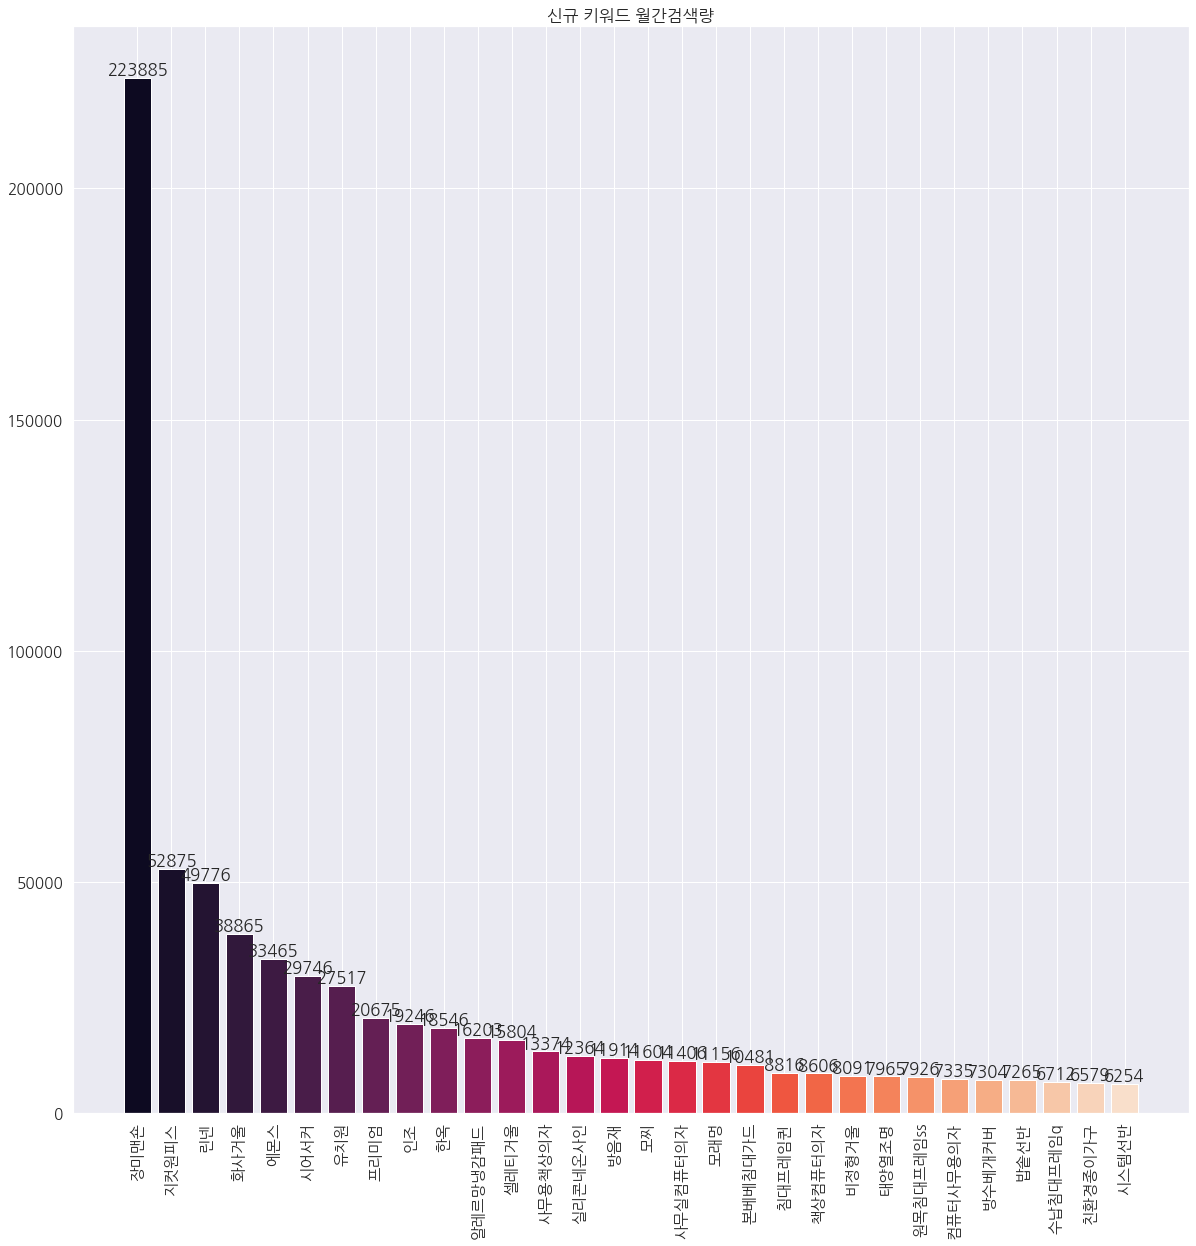

In [39]:
create_barplot()

In [86]:
# heatplot() ; 단일 키워드 열지도 시각화
def heatplot():
    """
    키워드의 검색량을 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])
    
    # keyword = 조회할 키워드 입력
    keyword = input("검색량을 조회할 키워드 입력: ")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_' + keyword + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
162  2022-06-12     친환경종이가구
161  2022-06-12       시스템선반
160  2022-06-11       침대옆협탁
159  2022-06-11     천연라텍스베개
158  2022-06-11     거실장2000
..          ...         ...
1    2022-05-13         소음재
5    2022-05-13      학생책상의자
6    2022-05-13  릴리4인용세라믹식탁
7    2022-05-13     컴퓨터학생의자
0    2022-05-13         쪽가위

[163 rows x 2 columns]
검색량을 조회할 키워드 입력: 실리콘네온사인


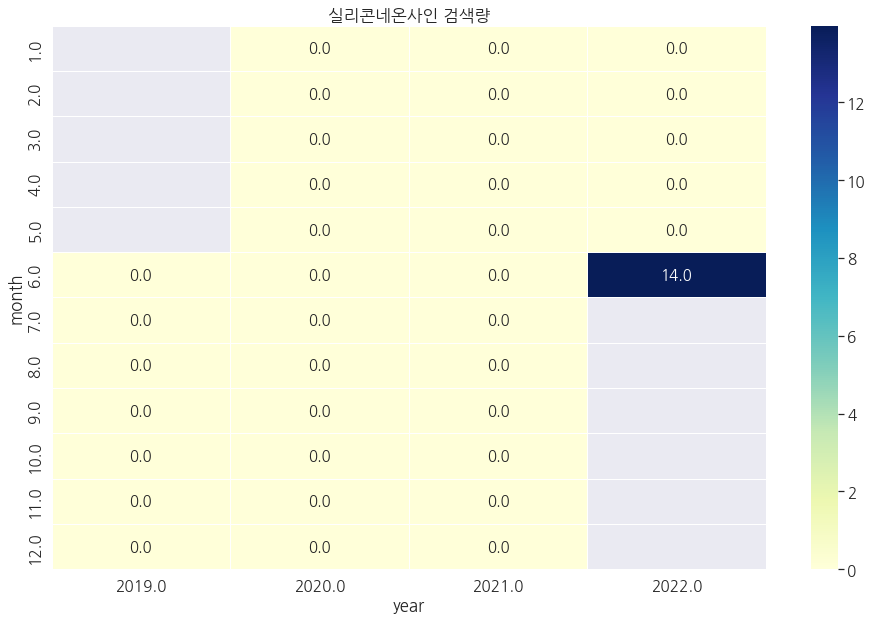

In [72]:
heatplot()

In [45]:
# heatplot_compare() ; 키워드 비교 열지도 시각화
def heatplot_compare():
    """
    '키워드1' vs '키워드2' 검색량을 비교해서 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])

    # keyword1, keyword2 = 조회할 키워드 입력
    keyword1 = input("검색량을 조회할 키워드1 입력 :")
    keyword2 = input("검색량을 조회할 키워드2 입력 :")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword1), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax1)
    sns.heatmap(df_ym.pivot("month", "year", keyword2), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax2)
    ax1.set_title(keyword1 + " 검색량")
    ax2.set_title(keyword2 + " 검색량")
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_' + keyword1 + 'vs' + keyword2 + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
162  2022-06-12     친환경종이가구
161  2022-06-12       시스템선반
160  2022-06-11       침대옆협탁
159  2022-06-11     천연라텍스베개
158  2022-06-11     거실장2000
..          ...         ...
1    2022-05-13         소음재
5    2022-05-13      학생책상의자
6    2022-05-13  릴리4인용세라믹식탁
7    2022-05-13     컴퓨터학생의자
0    2022-05-13         쪽가위

[163 rows x 2 columns]
검색량을 조회할 키워드1 입력 :도토리수납함
검색량을 조회할 키워드2 입력 :야외이동주방


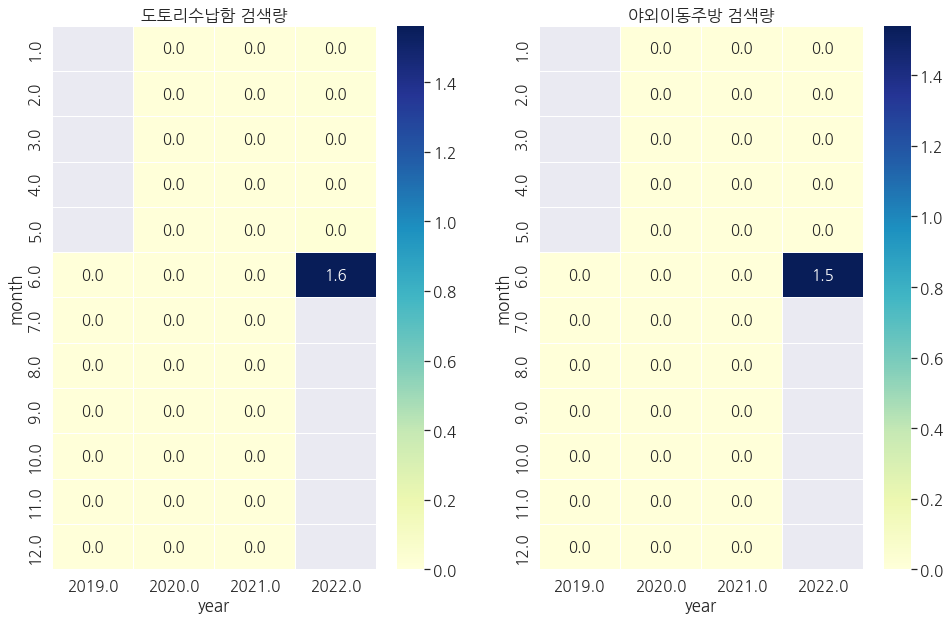

In [46]:
heatplot_compare()

# 키워드 네트워크 시각화용 자료 수집

In [47]:
# df_m = pd.read_csv('C:/project/CODE/keyword/data/furniture/output/' + yesterday + '_trendy_furniture_keywords.csv', encoding='UTF-8', index_col=0)

In [48]:
# 

In [49]:
def related_word_parse(word_list, n): 
    """
    검색어의 연관검색어를 반복해서 검색하는 함수입니다.
    ...
    word_list = 검색할 키워드 값이 있는 리스트
    n = 검색어의 연관검색어를 거듭진행할 회차 수 (일단은 3번 위주로)
    """
    if n==0:
        print('작업 종료')
        
    else:
        merge_df = pd.DataFrame()
        for i in tqdm(range(len(word_list))):
            temp_df = pd.DataFrame()
            temp_list = []
            url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query=' + word_list[i]
            r = requests.get(url)
            soup_r = bs4.BeautifulSoup(r.text, 'lxml')
            print(word_list[i])
            result = soup_r.select('ul.lst_related_srch > li.item')
            time.sleep(1)
            
            
            try:
                result = soup_r.select('ul.lst_related_srch > li.item')
            
            
            # 연관검색어가 없는 키워드일 때 예외처리
            except:
                if pd.isna(result):
                    result = []
                
                    
            if len(result) == 0:
                pass
            
            else:
                for k in result:
                    temp_list.append(k.text.replace("  ",""))
                
                temp_df['sub_word'] = temp_list
                temp_df['sup_word'] = word_list[i]
                temp_df = pd.DataFrame(temp_df, columns=['sup_word', 'sub_word'])
                
                merge_df = pd.concat([merge_df, temp_df], axis=0)
                
        # 반복회차 결과 저장
        dictionary[n] = merge_df

        # 반복호출
        pass_word_list = merge_df['sub_word'].values

        print('==========다음 회차 시작')
        related_word_parse(pass_word_list, n-1)


In [50]:
dictionary = {}
len(lis)

317

In [51]:
# len(df_m_list)

In [52]:
related_word_parse(lis, 2)

  0%|          | 0/317 [00:00<?, ?it/s]

실내용디퓨저byldf001천연디퓨저
천연디퓨저실내용디퓨저byldf001
헤링본여름쿨매트
천연디퓨저디퓨저byldf001실내용
실내용byldf001천연디퓨저디퓨저
천연디퓨저디퓨저실내용byldf001
실내용byldf001디퓨저천연디퓨저
실내용천연디퓨저byldf001디퓨저
쪽가위
실내용천연디퓨저디퓨저byldf001
마켓비원목선반
소음재
모래멍
책상컴퓨터의자
양면암막커튼
학생책상의자
메트로캔들워머
릴리4인용세라믹식탁
컴퓨터학생의자
빨아쓰는발매트
헬시메이트블랙라벨기능성메모리폼경추베개
오에스퍼니처osg100컴퓨터게이밍의자
원목4인식탁세트벤치+의자형
장미맨숀
전자렌지밥솥오븐수납장선반
전자레인지밥솥오븐선반수납장600
사무용책상의자
실내용디퓨저
실내용천연디퓨저
무볼트앵글
모던티비다이
데코지오쉐도우아일렛형암막커튼일반커튼방한커튼가리개커튼
편백깔판
르올바디필로우
실내분수
우드행거
원목침대프레임ss
투에이치몰슈퍼싱글이불
헤링본쿨매트
시스템행거2단행거
여름이불60수
태양열조명
컴피플러피60수순면피그먼트패드라지킹이스턴킹
방수베개커버
릴리즈철제캔들홀더촛불양초티라이트받침
선인장소품홈데코귀여운인테리어장식소품w95683b
아망뜨북유럽풍가죽식탁매트감성사각테이블매트
아쿠아텍스3인용패브릭소파
사무용컴퓨터의자블랙
바퀴달린책상사이드테이블소파옆내추럴z형
에르고휴먼
아쿠아텍스패브릭2인
더식스슈퍼싱글매트리스
잠솔솔
리빙제이
발릴라
화이트소프트매트리스
마켓비모듈수납장
메모리폼매트리스ss
스마일무소음해머벨탁상시계방긋인테리어시계
거실속커튼
거실쉬폰커튼
무지천
린즈홈
맞춤제작수납선반철제팬트리모듈다용도조립미니랙
조립식diy선반
매트리스깔판패밀리받침대
오가닉순면100줄누빔
코난범인무드등
프리미엄
경추베개스탠바이미
기능성
시디즈메쉬의자
휴레카편백나무메모리폼베개0066
트웸코
유지연작가한정판인테리어액자
평상형원목침대프레임ss
컴퓨터사무용의자
비정형거울
책상사무용의자
사무용의자모드니
골드에디션디퓨저200ml1+1
방수실리콘식탁매트
린넨호텔식암막커튼
방향제디퓨저
인테리어방향제
디퓨저2개
식탁세트의자2개
알레르망냉감패드
식탁스타

  0%|          | 0/541 [00:00<?, ?it/s]

일제쪽가위
고급쪽가위
일본쪽가위
삼덕쪽가위
슬로우 모래멍
모래멍샌드아트
고등학생책상의자
편한책상의자
빨아쓰는 규조토 발매트
발매트
무볼트앵글선반
앵글
무볼트 선반
높은 티비다이
철제티비다이
대리석티비다이
미니 티비다이
티비다이인테리어
낮은 티비다이
원목 티비다이 
심플티비다이
고급티비다이
티비다이 1800
실내 분수대
미니분수
태양광분수
가정용 분수
태양열 분수
연못분수
인테리어 분수
실내연못
분수노즐
실내 폭포
우드 미니 행거
우드선반행거
우드2단행거
우드벽걸이행거
시스템행거
이동식 행거
벽행거
옷걸이행거
원목행거
철제행거
태양열 캠핑조명
태양광 조명
태양열 가로등
테라스 조명
태양열 전구
태양열 전등
태양열 알전구
실외조명
태양열 led
태양열 벽부등
방수베개속커버
메모리폼베개방수커버
베개커버5070
베개커버4060
베개커버3050
라텍스베개커버
호텔베개커버
둥근베개커버
린넨베개커버
80수 베개커버
에르고휴먼v2
에르고휴먼의자
잠솔솔 베개
리빙제이 잠솔솔
리빙제이 베개
리빙제이 잠솔솔
발릴라 매트리스
발릴라 제빵기
발릴라 몽제
발릴라꼬띠
발릴라 쿡스타일러
발릴라 아이스크림
거실속커튼 인테리어
거실속커튼 커텐
거실속커튼 아파트
거실속커튼 암막
거실속커튼 분위기
거실 커튼
대전 현대프리미엄아웃렛
유튜브 프리미엄 우회
유튜브 프리미엄
김치프리미엄
유튜브 프리미엄 가격
호관원 프리미엄 가격
롯데시네마 프리미엄구미센트럴
프리미엄 고속버스
아로나민 골드 프리미엄
유튜브 프리미엄 해지
기능성 반팔
나이키 기능성 반팔
기능성 반팔티
기능성 긴팔
기능성 티셔츠
슈올즈 기능성신발
기능성신발깔창
기능성방석
남자 기능성 반팔
나이키 기능성 긴팔
트웸코 시계
트웸코 qt-30
비정형전신거울
비정형벽거울
비정형led거울
비정형화장대거울
비정형 탁상거울
비정형벽걸이거울
비정형조명거울
현관 비정형 거울
비정형 거울 대형
비정형 아크릴 거울
알레르망 아스토 냉감패드
알레르망 쿨레이 냉감패드
알레르망 냉감패드 세탁
알레르망 냉감패드 q
냉감패드
세사 냉감패드
세사리빙 냉감패드
알레르망 인

In [53]:
# 파싱 결과 병합 작업

In [54]:
dictionary[2]

,sup_word,sub_word
0,쪽가위,일제쪽가위
1,쪽가위,고급쪽가위
2,쪽가위,일본쪽가위
3,쪽가위,삼덕쪽가위
0,모래멍,슬로우 모래멍
...,...,...
4,친환경종이가구,툭 종이가구
5,친환경종이가구,나혼산 종이가구
6,친환경종이가구,종이가구 툭
7,친환경종이가구,친환경종이 선반


In [55]:
dictionary[1]

,sup_word,sub_word
0,고등학생책상의자,고등학생책상
0,편한책상의자,컴퓨터책상의자
1,편한책상의자,허리 편한의자
2,편한책상의자,학생 책상의자
3,편한책상의자,접이식책상의자
...,...,...
5,종이가구 툭,툭
0,친환경종이 선반,친환경 종이 가구
1,친환경종이 선반,친환경 선반
0,친환경 종이 책장,종이책장


In [56]:
merge1 = pd.merge(dictionary[2], dictionary[1], left_on='sub_word', right_on='sup_word')
merge1

,sup_word_x,sub_word_x,sup_word_y,sub_word_y
0,학생책상의자,고등학생책상의자,고등학생책상의자,고등학생책상
1,학생책상의자,편한책상의자,편한책상의자,컴퓨터책상의자
2,학생책상의자,편한책상의자,편한책상의자,허리 편한의자
3,학생책상의자,편한책상의자,편한책상의자,학생 책상의자
4,학생책상의자,편한책상의자,편한책상의자,접이식책상의자
...,...,...,...,...
3381,친환경종이가구,종이가구 툭,종이가구 툭,툭
3382,친환경종이가구,친환경종이 선반,친환경종이 선반,친환경 종이 가구
3383,친환경종이가구,친환경종이 선반,친환경종이 선반,친환경 선반
3384,친환경종이가구,친환경 종이 책장,친환경 종이 책장,종이책장


In [57]:
merge1 = merge1.drop(['sub_word_x'], axis=1)
merge1.columns = ['sup_word', 'sub_word1','sub_word2']
merge1

,sup_word,sub_word1,sub_word2
0,학생책상의자,고등학생책상의자,고등학생책상
1,학생책상의자,편한책상의자,컴퓨터책상의자
2,학생책상의자,편한책상의자,허리 편한의자
3,학생책상의자,편한책상의자,학생 책상의자
4,학생책상의자,편한책상의자,접이식책상의자
...,...,...,...
3381,친환경종이가구,종이가구 툭,툭
3382,친환경종이가구,친환경종이 선반,친환경 종이 가구
3383,친환경종이가구,친환경종이 선반,친환경 선반
3384,친환경종이가구,친환경 종이 책장,종이책장


In [58]:
# 작업결과 저장
total_words = merge1.copy()
total_words.to_csv('C:/project/CODE/keyword/data/furniture/network/' + yesterday + 'multiple_related_word_parse.csv', encoding='utf-8')
total_words

,sup_word,sub_word1,sub_word2
0,학생책상의자,고등학생책상의자,고등학생책상
1,학생책상의자,편한책상의자,컴퓨터책상의자
2,학생책상의자,편한책상의자,허리 편한의자
3,학생책상의자,편한책상의자,학생 책상의자
4,학생책상의자,편한책상의자,접이식책상의자
...,...,...,...
3381,친환경종이가구,종이가구 툭,툭
3382,친환경종이가구,친환경종이 선반,친환경 종이 가구
3383,친환경종이가구,친환경종이 선반,친환경 선반
3384,친환경종이가구,친환경 종이 책장,종이책장


## 여기서부터는 키워드 네트워크 시각화

In [59]:
##### 여기서부터는 임시 작업용 df 호출 #####
# total_words = pd.read_csv('C:/project/CODE/keyword/data/furniture/network/multiple_related_word_parse.csv', encoding='utf-8', index_col=0)
uniq_word = total_words.drop_duplicates(['sup_word'], keep='first')
uniq_wordlist = list(uniq_word['sup_word'])
uniq_wordlist

['학생책상의자',
 '빨아쓰는발매트',
 '무볼트앵글',
 '모던티비다이',
 '실내분수',
 '우드행거',
 '스피드랙행거',
 '태양열조명',
 '방수베개커버',
 '에르고휴먼',
 '잠솔솔',
 '리빙제이',
 '발릴라',
 '거실쉬폰커튼',
 '프리미엄',
 '기능성',
 '트웸코',
 '비정형거울',
 '알레르망냉감패드',
 '이불토퍼',
 '시어서커',
 '아로마버너',
 '방음재',
 '마지스트롤리',
 '본베베침대가드',
 '캥거루앞치마',
 '침대커튼',
 '스타벅스테이블',
 '초마루디퓨저',
 '메탈시트지',
 '한옥',
 '황금',
 '대리석소파테이블',
 '대리석거실테이블',
 '세라믹거실테이블',
 '암막커튼추천',
 '지컷원피스',
 '인조',
 '에몬스',
 '유치원',
 '사무용파티션',
 '린넨',
 '덴마크화병',
 '박술녀풍기인견이불',
 '셀레티거울',
 '밥솥선반',
 '실리콘네온사인',
 '소파3인용',
 '식탁6인용',
 '식탁세라믹',
 '식탁4인용',
 '침대프레임원목',
 '침대프레임퀸',
 '도토리수납함',
 '침대슈퍼싱글',
 '쇼파3인',
 '네이즌쿨매트',
 '패브릭스툴',
 '모찌',
 '접이식토퍼매트리스',
 '티비거실장',
 '고무나무식탁',
 '마켓비책상',
 '거실장2000',
 '천연라텍스베개',
 '침대옆협탁',
 '시스템선반',
 '친환경종이가구']

In [60]:
def create_nx_df():
    """
    키워드 연관도를 조회하기 위해 필터링된 데이터프레임을 만드는 함수입니다.
    ...
    """
#     global df_sup
    keyword = input("연관도를 조회할 키워드를 입력하세요: ")
    df_sup = total_words[total_words['sup_word'] == keyword]
    return(df_sup)

In [61]:
# create_nx_df()

In [62]:
def create_nx():
    """
    트렌드 키워드의 연관검색어들 
    """
    # 라이브러리
    import networkx as nx
    import matplotlib.font_manager as fm ; from matplotlib import rc
    # 폰트 설정
    font_name = fm.FontProperties(fname="c:/Windows/Fonts/HMKMMAG.ttf").get_name()

    
    print("조회가능힌 키워드 목록입니다.")
    print("=" * 50)
    print(uniq_wordlist)
    print("=" * 50)
    
    keyword = input("연관도를 조회할 키워드를 입력하세요: ")
    df_sup = total_words[total_words['sup_word'] == keyword]
    
    

    # 네트워크 생성
    G = nx.Graph()
    
    for sup in list(set(df_sup['sup_word'].values)):
        G.add_node(sup)
        temp_df1 = df_sup[df_sup['sup_word']==sup]
        for sub1 in list(set(temp_df1['sub_word1'].values)):
            G.add_node(sub1)
            G.add_edge(sup,sub1)
            temp_df2 = temp_df1[temp_df1['sub_word1']==sub1]
            for sub2 in list(set(temp_df2['sub_word2'].values)):
                G.add_node(sub2)
                G.add_edge(sub1,sub2)
                temp_df3 = temp_df2[temp_df2['sub_word2']==sub2]
                    
    title = list(df_sup['sup_word'])[0]
    color_map = []
    for node in G:
        if node == title:
            color_map.append('red')
        elif node in list(set(df_sup['sub_word1'].values)):
            color_map.append('orange')
        else:
            color_map.append('yellow')
            
    # 그래프 생성
    plt.figure(figsize=(20, 20))
    d = dict(G.degree)
    nx.draw(G,nodelist=d.keys(), node_size=[v * 1000 for v in d.values()], font_family=font_name,font_size=20, node_color = color_map, with_labels = True)
    # 한글 폰트에러 때문에 별도의 폰트 설정이 필요합니다.
    plt.axis('off')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_' + title + 'networkx_pic.png')
    plt.title(title + ' 연관어 관계도', fontsize=50)
    plt.show()
        

조회가능힌 키워드 목록입니다.
['학생책상의자', '빨아쓰는발매트', '무볼트앵글', '모던티비다이', '실내분수', '우드행거', '스피드랙행거', '태양열조명', '방수베개커버', '에르고휴먼', '잠솔솔', '리빙제이', '발릴라', '거실쉬폰커튼', '프리미엄', '기능성', '트웸코', '비정형거울', '알레르망냉감패드', '이불토퍼', '시어서커', '아로마버너', '방음재', '마지스트롤리', '본베베침대가드', '캥거루앞치마', '침대커튼', '스타벅스테이블', '초마루디퓨저', '메탈시트지', '한옥', '황금', '대리석소파테이블', '대리석거실테이블', '세라믹거실테이블', '암막커튼추천', '지컷원피스', '인조', '에몬스', '유치원', '사무용파티션', '린넨', '덴마크화병', '박술녀풍기인견이불', '셀레티거울', '밥솥선반', '실리콘네온사인', '소파3인용', '식탁6인용', '식탁세라믹', '식탁4인용', '침대프레임원목', '침대프레임퀸', '도토리수납함', '침대슈퍼싱글', '쇼파3인', '네이즌쿨매트', '패브릭스툴', '모찌', '접이식토퍼매트리스', '티비거실장', '고무나무식탁', '마켓비책상', '거실장2000', '천연라텍스베개', '침대옆협탁', '시스템선반', '친환경종이가구']
연관도를 조회할 키워드를 입력하세요: 친환경종이가구


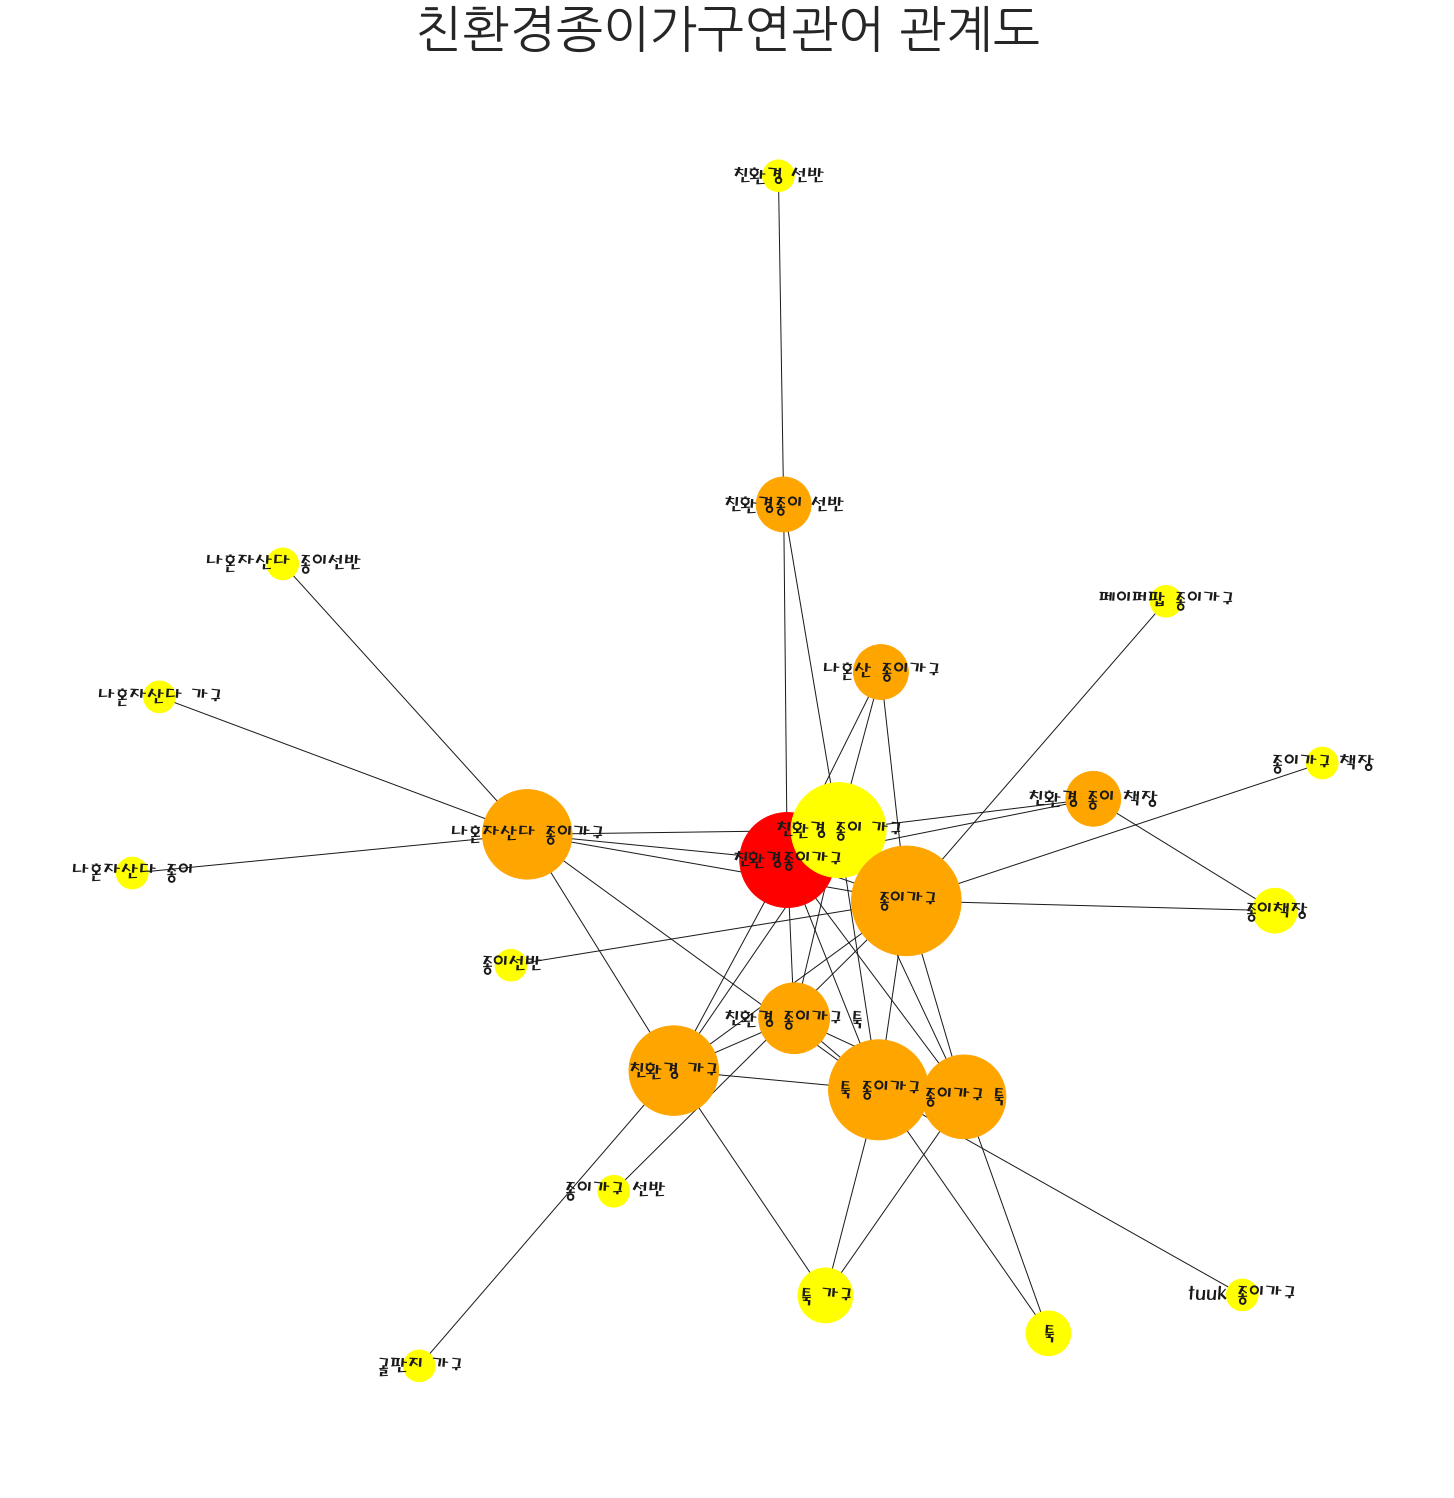

In [63]:
create_nx()

조회가능힌 키워드 목록입니다.
['학생책상의자', '빨아쓰는발매트', '무볼트앵글', '모던티비다이', '실내분수', '우드행거', '스피드랙행거', '태양열조명', '방수베개커버', '에르고휴먼', '잠솔솔', '리빙제이', '발릴라', '거실쉬폰커튼', '프리미엄', '기능성', '트웸코', '비정형거울', '알레르망냉감패드', '이불토퍼', '시어서커', '아로마버너', '방음재', '마지스트롤리', '본베베침대가드', '캥거루앞치마', '침대커튼', '스타벅스테이블', '초마루디퓨저', '메탈시트지', '한옥', '황금', '대리석소파테이블', '대리석거실테이블', '세라믹거실테이블', '암막커튼추천', '지컷원피스', '인조', '에몬스', '유치원', '사무용파티션', '린넨', '덴마크화병', '박술녀풍기인견이불', '셀레티거울', '밥솥선반', '실리콘네온사인', '소파3인용', '식탁6인용', '식탁세라믹', '식탁4인용', '침대프레임원목', '침대프레임퀸', '도토리수납함', '침대슈퍼싱글', '쇼파3인', '네이즌쿨매트', '패브릭스툴', '모찌', '접이식토퍼매트리스', '티비거실장', '고무나무식탁', '마켓비책상', '거실장2000', '천연라텍스베개', '침대옆협탁', '시스템선반', '친환경종이가구']
연관도를 조회할 키워드를 입력하세요: 실리콘네온사인


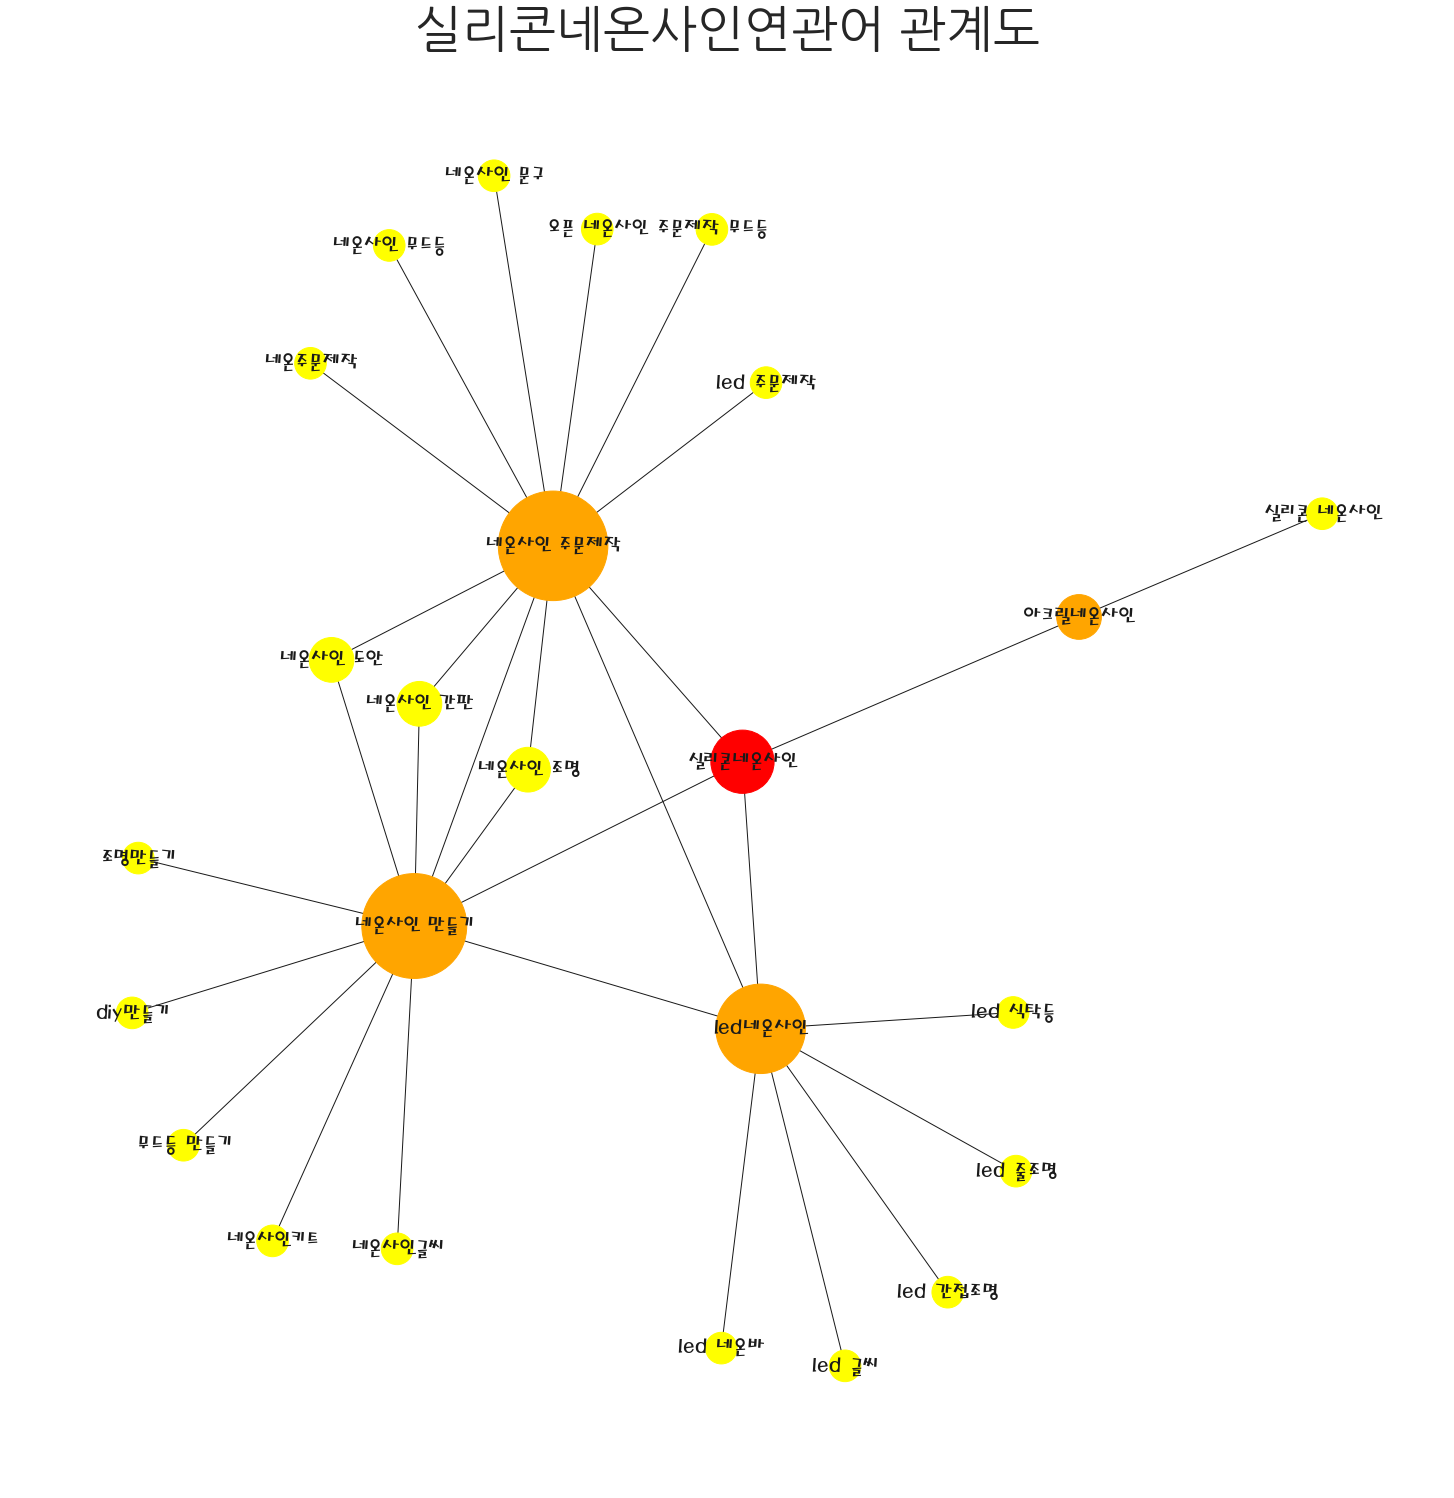

In [73]:
create_nx()

조회가능힌 키워드 목록입니다.
['학생책상의자', '빨아쓰는발매트', '무볼트앵글', '모던티비다이', '실내분수', '우드행거', '스피드랙행거', '태양열조명', '방수베개커버', '에르고휴먼', '잠솔솔', '리빙제이', '발릴라', '거실쉬폰커튼', '프리미엄', '기능성', '트웸코', '비정형거울', '알레르망냉감패드', '이불토퍼', '시어서커', '아로마버너', '방음재', '마지스트롤리', '본베베침대가드', '캥거루앞치마', '침대커튼', '스타벅스테이블', '초마루디퓨저', '메탈시트지', '한옥', '황금', '대리석소파테이블', '대리석거실테이블', '세라믹거실테이블', '암막커튼추천', '지컷원피스', '인조', '에몬스', '유치원', '사무용파티션', '린넨', '덴마크화병', '박술녀풍기인견이불', '셀레티거울', '밥솥선반', '실리콘네온사인', '소파3인용', '식탁6인용', '식탁세라믹', '식탁4인용', '침대프레임원목', '침대프레임퀸', '도토리수납함', '침대슈퍼싱글', '쇼파3인', '네이즌쿨매트', '패브릭스툴', '모찌', '접이식토퍼매트리스', '티비거실장', '고무나무식탁', '마켓비책상', '거실장2000', '천연라텍스베개', '침대옆협탁', '시스템선반', '친환경종이가구']
연관도를 조회할 키워드를 입력하세요: 친환경종이가구


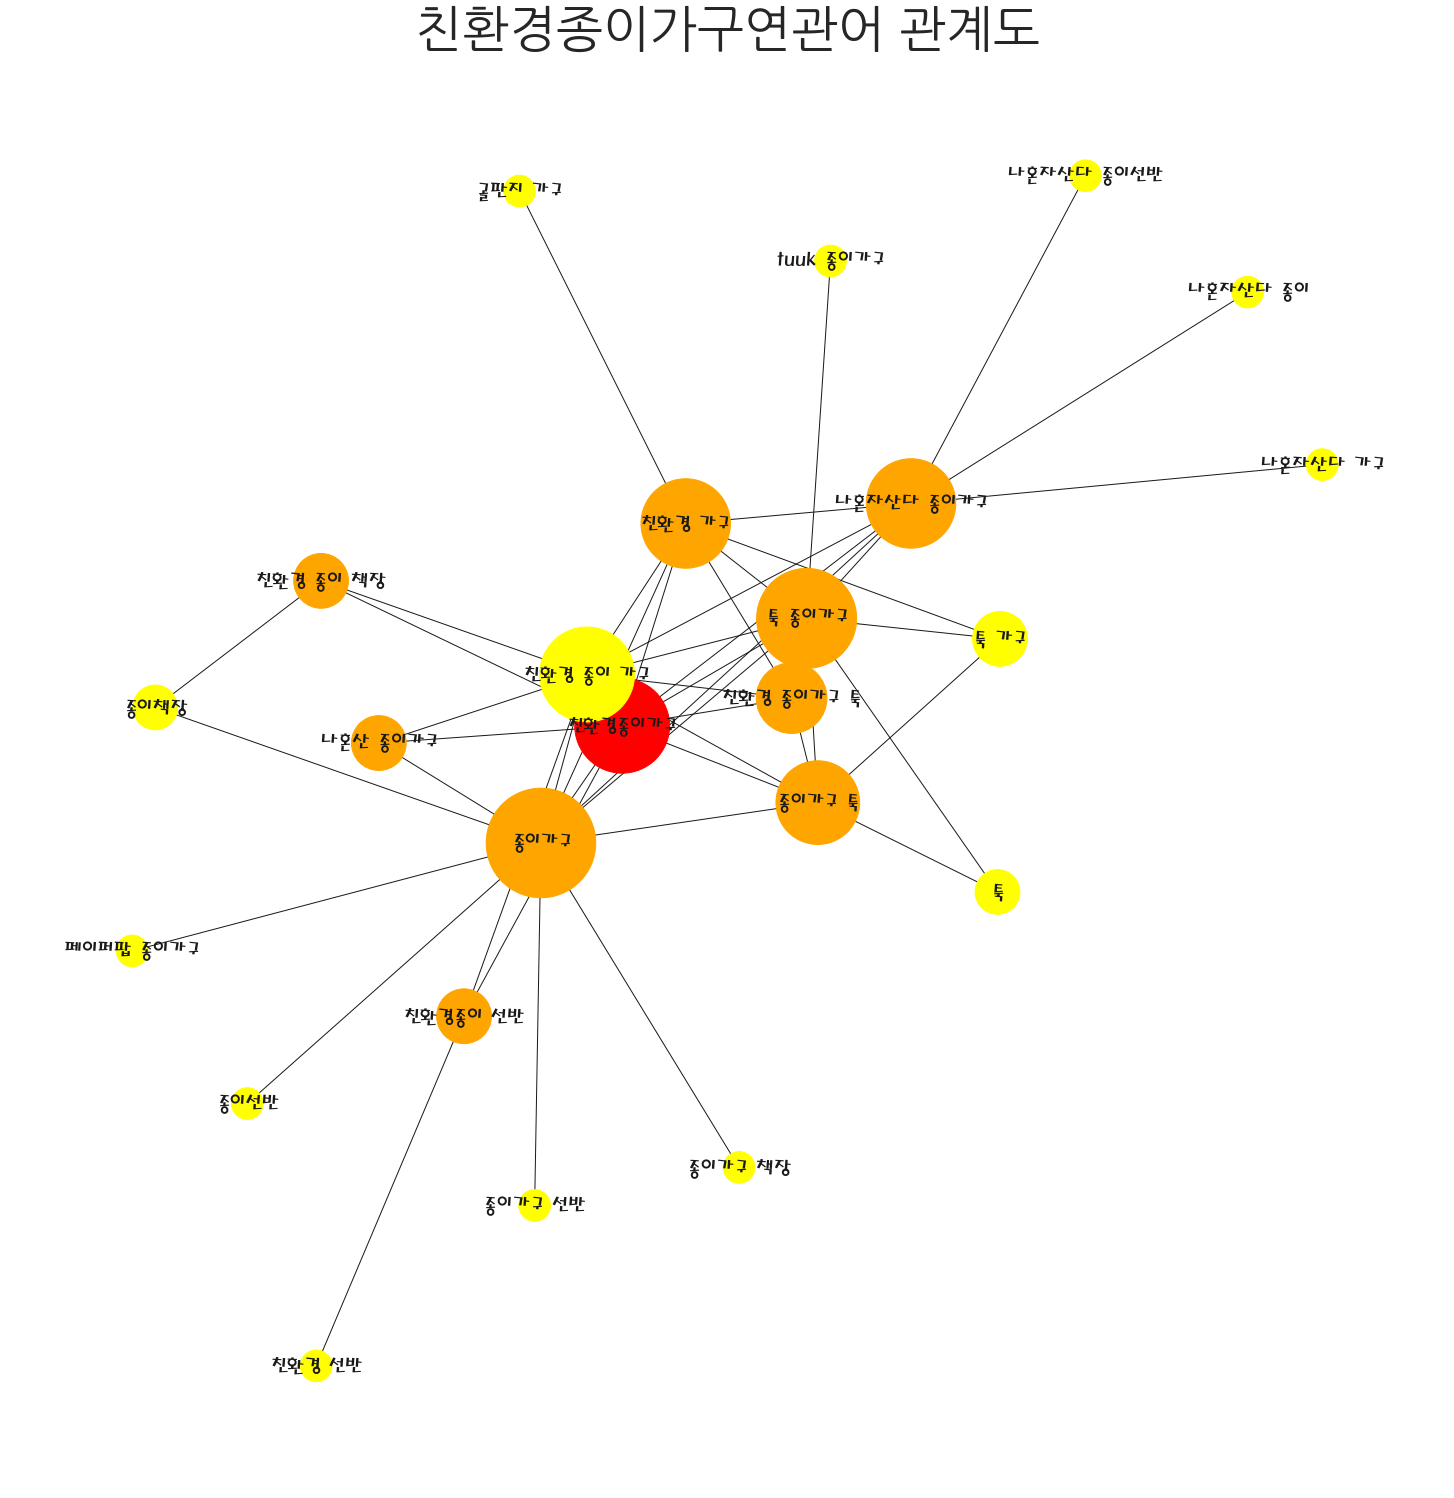

In [93]:
create_nx()

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
162  2022-06-12     친환경종이가구
161  2022-06-12       시스템선반
160  2022-06-11       침대옆협탁
159  2022-06-11     천연라텍스베개
158  2022-06-11     거실장2000
..          ...         ...
1    2022-05-13         소음재
5    2022-05-13      학생책상의자
6    2022-05-13  릴리4인용세라믹식탁
7    2022-05-13     컴퓨터학생의자
0    2022-05-13         쪽가위

[163 rows x 2 columns]
검색량을 조회할 키워드 입력: 세라믹거실테이블


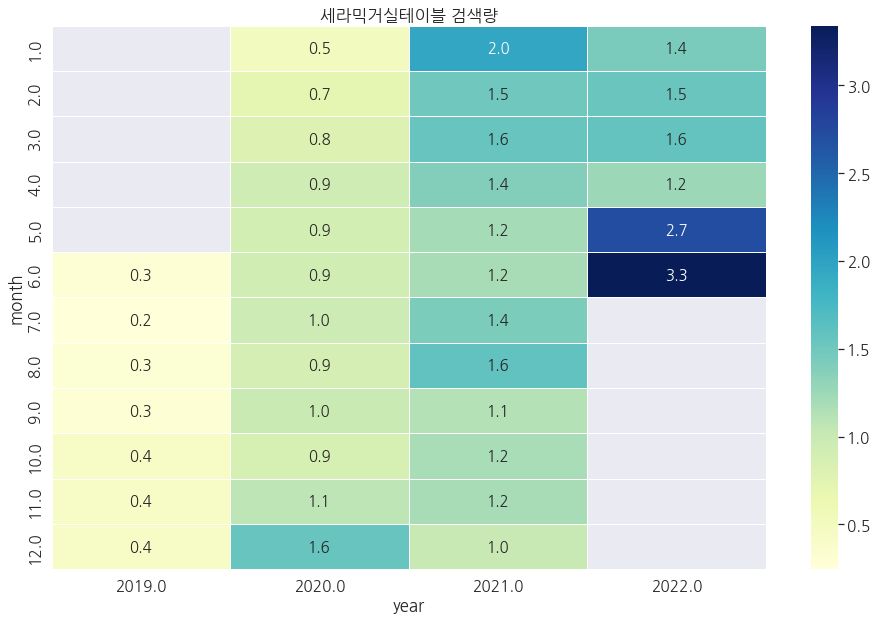

In [80]:
heatplot()

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
162  2022-06-12     친환경종이가구
161  2022-06-12       시스템선반
160  2022-06-11       침대옆협탁
159  2022-06-11     천연라텍스베개
158  2022-06-11     거실장2000
..          ...         ...
1    2022-05-13         소음재
5    2022-05-13      학생책상의자
6    2022-05-13  릴리4인용세라믹식탁
7    2022-05-13     컴퓨터학생의자
0    2022-05-13         쪽가위

[163 rows x 2 columns]
검색량을 조회할 키워드 입력: 암막커튼추천


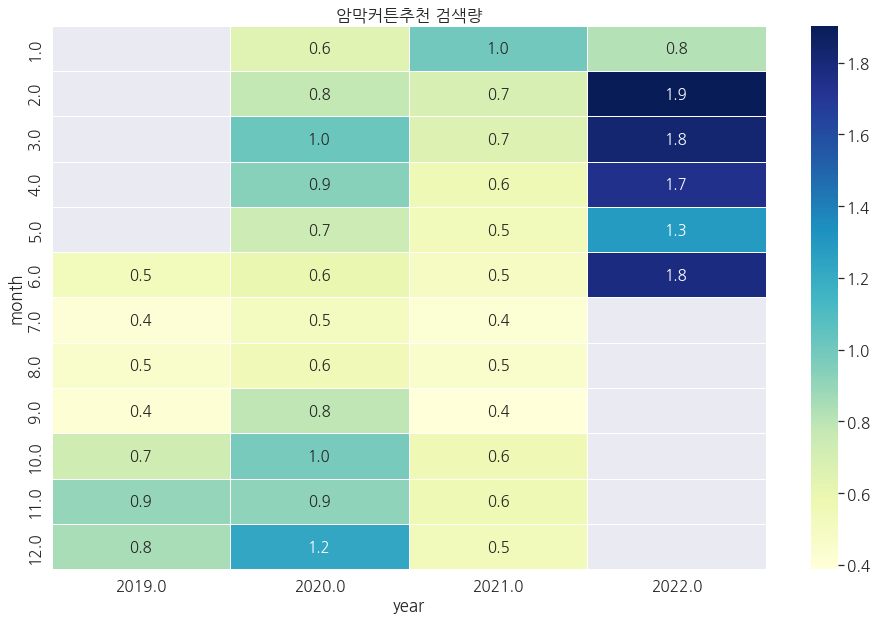

In [81]:
heatplot()

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
162  2022-06-12     친환경종이가구
161  2022-06-12       시스템선반
160  2022-06-11       침대옆협탁
159  2022-06-11     천연라텍스베개
158  2022-06-11     거실장2000
..          ...         ...
1    2022-05-13         소음재
5    2022-05-13      학생책상의자
6    2022-05-13  릴리4인용세라믹식탁
7    2022-05-13     컴퓨터학생의자
0    2022-05-13         쪽가위

[163 rows x 2 columns]
검색량을 조회할 키워드 입력: 침대옆협탁


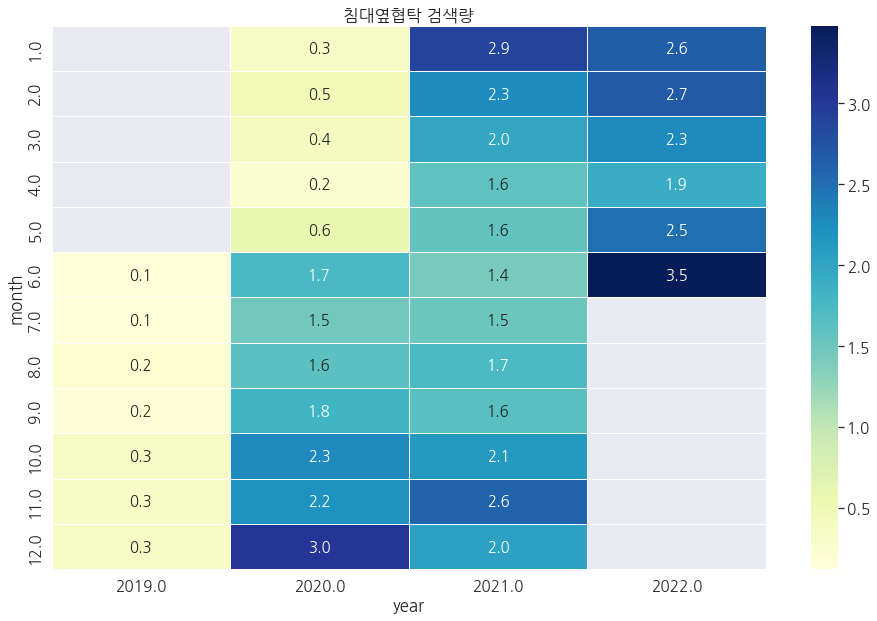

In [82]:
heatplot()

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
162  2022-06-12     친환경종이가구
161  2022-06-12       시스템선반
160  2022-06-11       침대옆협탁
159  2022-06-11     천연라텍스베개
158  2022-06-11     거실장2000
..          ...         ...
1    2022-05-13         소음재
5    2022-05-13      학생책상의자
6    2022-05-13  릴리4인용세라믹식탁
7    2022-05-13     컴퓨터학생의자
0    2022-05-13         쪽가위

[163 rows x 2 columns]
검색량을 조회할 키워드 입력: 천연라텍스베개


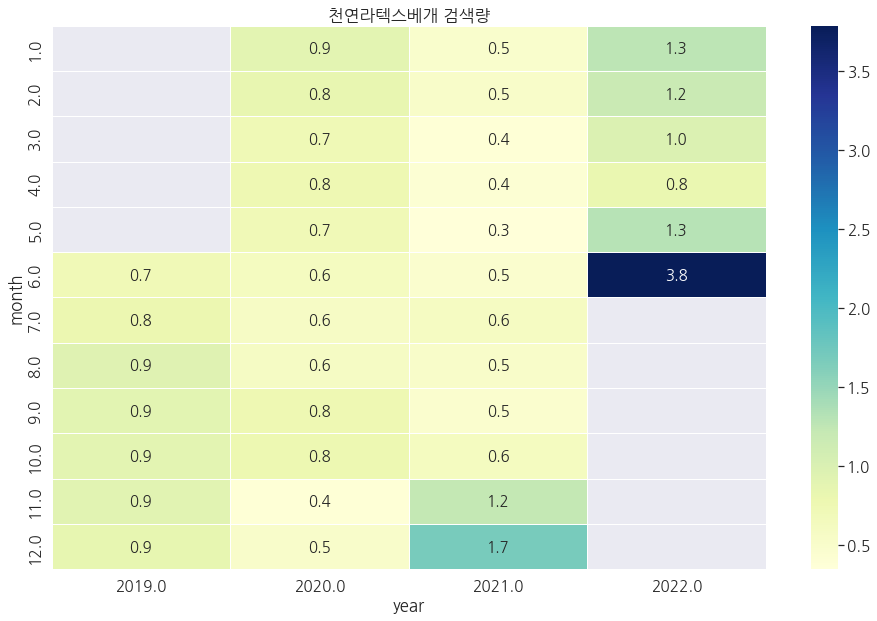

In [87]:
heatplot()

### 조회 가능한 키워드 정보 ###
           등장일자         키워드
162  2022-06-12     친환경종이가구
161  2022-06-12       시스템선반
160  2022-06-11       침대옆협탁
159  2022-06-11     천연라텍스베개
158  2022-06-11     거실장2000
..          ...         ...
1    2022-05-13         소음재
5    2022-05-13      학생책상의자
6    2022-05-13  릴리4인용세라믹식탁
7    2022-05-13     컴퓨터학생의자
0    2022-05-13         쪽가위

[163 rows x 2 columns]
검색량을 조회할 키워드 입력: 시스템선반


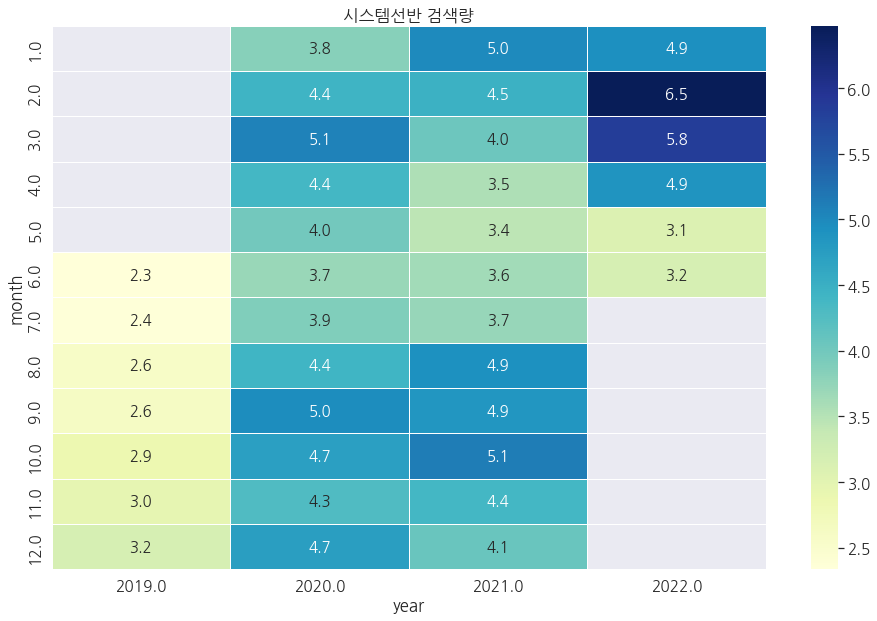

In [88]:
heatplot()

In [64]:
df_ym

소파  친환경종이가구  시스템선반  침대옆협탁  천연라텍스베개  거실장2000  이동식철제행거  티비거실장  \
기간   기간                                                                  
2019 6  39.99     0.00   2.34   0.14     0.71     0.24     0.00   1.38   
     7  41.24     0.00   2.35   0.12     0.79     0.21     0.00   1.42   
     8  43.70     0.00   2.57   0.21     0.94     0.23     0.00   1.50   
     9  44.28     0.00   2.61   0.17     0.91     0.26     0.01   1.64   
     10 45.92     0.00   2.86   0.35     0.89     0.26     0.01   1.73   
     11 47.59     0.00   2.96   0.33     0.91     0.26     0.01   1.87   
     12 49.09     0.00   3.17   0.34     0.85     0.30     0.01   2.03   
2020 1  53.16     0.00   3.83   0.31     0.88     0.28     0.01   2.18   
     2  62.84     0.00   4.42   0.47     0.84     0.42     0.01   2.23   
     3  68.50     0.00   5.07   0.39     0.73     0.48     0.02   2.45   
     4  71.52     0.00   4.37   0.25     0.76     0.37     0.02   2.44   
     5  64.58     0.00   4.00   0.58     0.72     0.38     0.02   2.11   
     6  58.76     0.00   3.70   1.74     0.61     0.32     0.01   1.84   
     7  59.42     0.00   3.88   1.47     0.57     0.38     0.02   1.95   
     8  65.87     0.00   4.42   1.61     0.58     0.47     0.01   2.25   
     9  67.43     0.00   4.96   1.81     0.75     0.43     0.01   2.31   
     10 62.80     0.00   4.73   2.28     0.76     0.44     0.02   1.93   
     11 63.29     0.00   4.29   2.21     0.38     0.42     0.03   1.95   
     12 69.18     0.00   4.73   3.03     0.51     0.40     0.01   2.26   
2021 1  71.49     0.00   5.00   2.90     0.48     0.39     0.04   2.24   
     2  66.85     0.00   4.48   2.25     0.52     0.43     0.02   2.17   
     3  62.68     0.00   4.04   1.97     0.38     0.36     0.03   2.08   
     4  59.24     0.00   3.55   1.60     0.41     0.28     0.01   1.74   
     5  57.83     0.00   3.45   1.57     0.34     0.27     0.01   1.51   
     6  56.74     0.00   3.63   1.42     0.47     0.25     0.02   1.44   
     7  58.39     0.00   3.72   1.52     0.60     0.32     0.00   1.38   
     8  67.37     0.00   4.91   1.72     0.52     0.39     0.01   1.63   
     9  67.97     0.00   4.85   1.64     0.48     0.41     1.04   1.47   
     10 68.04     0.00   5.12   2.12     0.62     0.31     1.12   1.31   
     11 57.17     0.00   4.38   2.59     1.22     0.37     0.92   1.29   
     12 51.77     0.00   4.08   2.05     1.69     0.35     0.23   1.23   
2022 1  57.48     0.00   4.94   2.63     1.27     0.34     0.45   1.68   
     2  66.95     0.00   6.48   2.68     1.18     1.48     1.34   1.59   
     3  54.78     0.00   5.84   2.28     0.99     0.32     1.37   1.42   
     4  50.12     0.00   4.88   1.90     0.81     0.26     1.08   1.21   
     5  50.65     0.00   3.09   2.49     1.30     1.20     0.45   1.57   
     6  52.91     8.30   3.16   3.48     3.79     2.99     1.01   3.13   

         다용도4단서랍장  고무나무식탁  ...  양면암막커튼  모래멍  책상컴퓨터의자  소음재  학생책상의자  릴리4인용세라믹식탁  \
기간   기간                    ...                                                  
2019 6       0.00    0.85  ...    0.00 0.00     0.00 0.00    0.12        0.00   
     7       0.00    0.78  ...    0.00 0.00     0.00 0.00    0.07        0.00   
     8       0.00    0.85  ...    0.00 0.00     0.00 0.00    0.13        0.00   
     9       0.00    0.85  ...    0.00 0.00     0.00 0.01    0.10        0.00   
     10      0.00    2.21  ...    0.00 0.00     0.00 0.00    0.10        0.00   
     11      0.00    1.77  ...    0.00 0.00     0.00 0.00    0.12        0.00   
     12      0.00    1.58  ...    0.02 0.00     0.00 0.01    0.13        0.00   
2020 1       0.00    1.48  ...    0.01 0.00     0.00 0.00    0.19        0.00   
     2       0.00    1.33  ...    0.00 0.00     0.00 0.00    0.25        0.00   
     3       0.00    1.25  ...    0.02 0.00     0.00 0.01    0.34        0.00   
     4       0.00    1.21  ...    0.01 0.00     0.00 0.00    0.48        0.00   
     5       0.00    1.26  ...    0.01 0.00     0.00 0.00    0.38      

In [65]:
# heatplot() ; 단일 키워드 열지도 시각화
def heatplot_type2(keyword_name):
    """
    키워드의 검색량을 볼 수 있는 시계열 열지도 생성 함수입니다.
    ...
    keyword = 열지도를 생성하고싶은 키워드
    """
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym_instant.pivot("month", "year", keyword_name), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword_name + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/furniture/figs/' + yesterday + '_' + keyword_name + '_히트맵차트.png', bbox_inches='tight')

In [66]:
# datalab_api
def datalab_api_single(keywords):
    """
    네이버 데이터랩 API를 활용해 입력된 키워드의 최근 3년간 일자별 검색량을 조회하는 함수입니다.
    ...
    list_name = 검색량을 조회하고자 하는 키워드
    """
    
    # 데이터랩 API 계정 및 url 정보
    client_id = "kJG1RgASjzoPJ2bpUq8L"    
    client_secret = "LBYXkCdlRf"
    url = "https://openapi.naver.com/v1/datalab/search"
    
    # 조회 조건 설정
    '''
    startdate = 검색량 조회 시작일자
    enddate = 검색량 조회 종료일자
    timeunit = 검색량 수집 기준
    keywordgroups = 조회를 원하는 키워드 그룹
    '''
    body = {
        "startDate":time_three_years,
        "endDate":yesterday,
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]}
        ],
    }
    
    # 검색량 조회 결과값이 들어있는 딕셔너리 변수
    body = json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 조회한 5개의 키워드 검색량을 각각의 데이터프레임에 저장
    df1 = pd.DataFrame(json_obj['results'][0]['data'])
    df2 = pd.DataFrame(json_obj['results'][1]['data'])

    
    
    # 딕셔너리 안에 조회 결과가 들어있지 않아서 데이터프레임을 생성하지 못할 시 오류가 발생하는 경우를 방지하기 위한 반복문
    # 데이터프레임 생성에 실패한 경우 값이 0으로 채워진 데이터프레임을 생성
    df_list = [df1,df2]
    for i in tqdm(range(len(df_list))):
        if len(list(df_list[i].columns)) ==2:
            df_list[i].columns=['기간', str(keywords[i])]
        elif len(list(df_list[i].columns)) ==0:
            df_list[i]['기간'] = 0
            df_list[i][str(keywords[i])] = 0

    # 5개의 키워드 검색량 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)

    return df2

In [67]:
# datalab_api_keylist
def datalab_api_instant():
    """
    기준 키워드를 기준으로 최소-최대 정규화를 적용한 데이터랩 검색량을 추출하는 함수입니다.
    검색량을 조회할 단일 키워드 input 값을 받아 실시간으로 검색량을 조회합니다.
    ...
    
    """
    
    keyword_name = input("조회하고 싶은 키워드를 입력하세요: ")
    list_x = [[]]
    list_x = ['소파'], [keyword_name]
    # df_api
    # 기준 키워드(잠옷)의 검색량 최소값과 최대값을 구하는 정규화 작업으로 키워드별 실제 검색량의 상대치를 보정합니다.
    df_api = datalab_api_single(list_x[0] + list_x[1])
    df_api = df_api.drop(['소파'], axis=1)
    a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
    
    
    # 저장
    df_api.to_csv('C:/project/CODE/keyword/data/furniture/query/' + yesterday + '_' + keyword_name + '_일자별_검색량.csv', encoding='UTF-8')

    
    
    
    
    # 히트맵 시각화용 데이터 프레임 생성
    df_api['기간']= pd.to_datetime(df_api['기간'])
    df_api['year'] = df_api['기간'].dt.year
    df_api['month'] = df_api['기간'].dt.month
    df_api['date'] = df_api['기간'].dt.date
    df_api = df_api.set_index('기간') # 년월일을 인덱스로 지정





    # df_ym
    # 연도와 월을 인덱스로 지정한 후 키워드 검색량을 연월로 그룹화해서 연월별 평균 검색량을 조회합니다.
    df_api['year'] = df_api.index.year; df_api['month'] = df_vis.index.month
    df_ym_instant = df_api.groupby([df_api.index.year, df_api.index.month]).mean()
    
    
    # 키워드 연월별 평균 검색량 열지도 시각화
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym_instant.pivot("month", "year", keyword_name), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword_name + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + keyword_name + '_히트맵차트.png', bbox_inches='tight')
    
    
    # 키워드 연월별 평균 검색량
#     return df_ym_instant


조회하고 싶은 키워드를 입력하세요: 나혼자산다 종이가구


  0%|          | 0/2 [00:00<?, ?it/s]

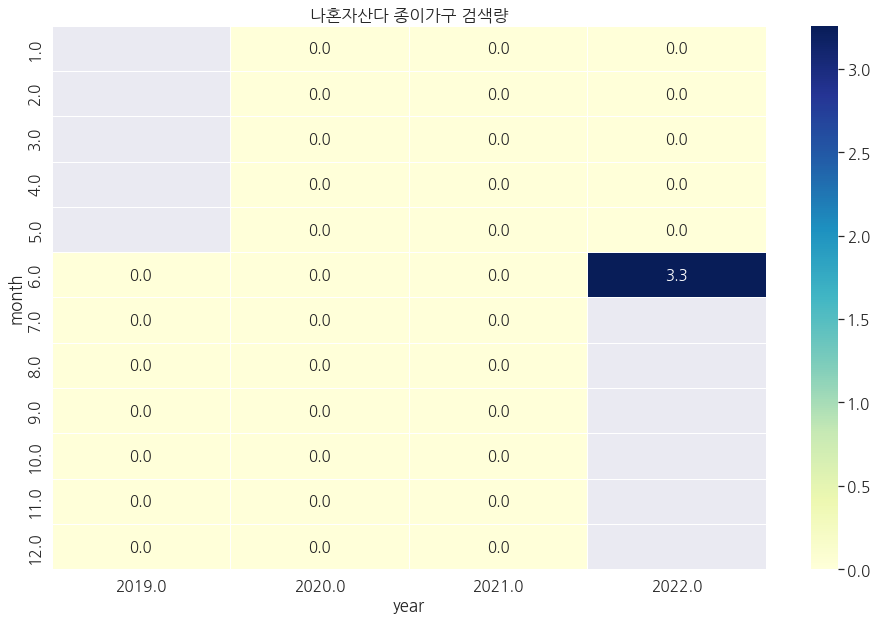

In [98]:
datalab_api_instant()

# 키워드 형태소분석 도전

In [189]:
# 라이브러리
import konlpy
import pickle

from konlpy.tag import Okt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [190]:
# from konlpy.tag import Okt
# okt 예시
# okt = Okt()
# print(okt.nouns(read_keywords)) # nouns = 명사

NameError: name 'read_keywords' is not defined

In [403]:
# df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/furniture/output/' + yesterday + '_trendy_furniture_keywords.csv', encoding='UTF-8', index_col=0)
df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/furniture/network/2022-06-11_multiple_related_word_parse.csv', encoding='UTF-8', index_col=0)
# write_keywords = list(df_konlpy[0])
# write_keywords

In [453]:
def create_wc_df():
    global df_wc
    """
    특정 키워드와 해당 키워드의 다중 연관검색어들을 워드클라우드로 시각화 하는 함수입니다.
    ...
    """
    print("조회가능힌 키워드 목록입니다.")
    print("=" * 50)
    print(uniq_wordlist)
    print("=" * 50)
    
    keyword = input("워드 클라우드를 조회할 키워드를 입력하세요: ")
    
    
    # 워드클라우드를 조회하기 위해 특정 키워드로 필터링된 데이터프레임 생성
    df_sup = df_konlpy[df_konlpy['sup_word'] == keyword]
    sup_word = list(df_konlpy.iloc[:,0])
    sub_word1 = list(df_konlpy.iloc[:,1])
    sub_word2 = list(df_konlpy.iloc[:,2])
    sub_word3 = list(df_konlpy.iloc[:,3])
    df_wc = sup_word + sub_word1 + sub_word2 + sub_word3
    
    return(df_wc)

In [454]:
create_wc_df()
    
#제목 및 본문 txt에 저장
text = open('trash.txt','w',encoding='UTF-8')
for i in df_wc:
    text.write(i)
    text.write(" ") # 띄어쓰기 구분
text.close()

# text 파일 읽어오기
text = open('trash.txt','rt', encoding='UTF-8').read()
# print("블로그 텍스트 내용: " + blog_text)

# Okt 함수를 이용해 형태소 분석
okt = Okt()
line =[]

line = okt.pos(text)

n_adj =[]
# 명사 또는 형용사인 단어만 n_adj에 넣어주기
for word, tag in tqdm(line):
    if tag in ['Noun']:
        n_adj.append(word)

# print(n_adj)

# 불용어 사전
f = open("C:/project/CODE/keyword/data/stopwords/stopwords_korean.txt", "rt", encoding="utf-8")
lines = f.readlines()
stop_words = []
for line in tqdm(lines):
    line = line.replace('\n', '') #txt 읽을 때 \n 제거
    stop_words.append(line)
f.close()
# stop_words

n_adj = [word for word in tqdm(n_adj) if not word in stop_words]

# print(line)
# print(n_adj)

remove_one_word = [x for x in tqdm(n_adj) if len(x)>1 or x=='핏' or x=='청' or x=='롱' or x=='티']


#가장 많이 나온 단어 n개 저장
counts = Counter(n_adj)
tags = counts.most_common(50) # 저장 개수 지정



# 이미지 추가(워드 클라우드 모양 설정)

mask = Image.new("RGBA",(1500,1500), (255,255,255)) #(2500,2500) = 이미지 크기, (255,255,255) = RGB
image = Image.open('C:/project/img/square.png').convert("RGBA")
x,y = image.size
mask.paste(image,(0,0,x,y),image)
mask = np.array(mask)

### 워드 클라우드 생성 ###
#폰트지정
# sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2)
font='C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/MALGUN.ttf'
word_cloud = WordCloud(font_path=font, background_color='black',max_font_size=400, mask=mask,colormap='prism').generate_from_frequencies(dict(tags))


# 사이즈 설정 및 화면에 출력
plt.figure(figsize=(24,24))
plt.imshow(word_cloud)
plt.axis('off')
#워드클라우드 사진으로 저장
#cloud.to_file('네이버_키워드_블로그_워드클라우드.png')
#또는
plt.savefig('C:/project/CODE/keyword/data/furniture/wordcloud/' + yesterday + 'wordcloud.png', bbox_inches='tight')
plt.show()



조회가능힌 키워드 목록입니다.
['교련복', '마르조썸머인견팬츠', '반팔크롭자켓', '반팔청자켓', '트위드반팔', '세루티자켓', '올리비아로렌티셔츠', '비비안마이핏네모팬티', '안나수이원피스', '테니스원피스', '리린', '가니송', '비뮤즈맨션', '러브이즈트루', '올앤선드리원피스', '안지크원피스', '나이스', '여성롱원피스', '법복', '나이키더블스우시후드집업', '여성여름정장', '유니클로마르니', '셀린느티셔츠', '디키즈874여자', '레이지카키하프조거팬츠', '여성반팔가디건', '테이핑브라', '신영와코루슬림업', '비비안컴포트브라', '유에르', '지오다노101221', '커클랜드티셔츠', '자바나스반팔', '신혼부부', '리스트바지', '폴로반팔셔츠', '리바이스쿨진여성', '엉뽕', '비비안컴포트브라팬티', '비비안컴포트', '맥스튜어트뉴욕데님', '바스락스커트', '세루티니트', '올리브그린썸머하이웨이팬츠', '코닥반팔티', '아우터']
워드 클라우드를 조회할 키워드를 입력하세요: 반팔크롭자켓


KeyboardInterrupt: 

In [428]:
# 데이터프레임 생성
create_wc_df()

#제목 및 본문 txt에 저장
text = open('trash.txt','w',encoding='UTF-8')
for i in to_wordcloud:
    text.write(i)
    text.write(" ") # 띄어쓰기 구분
text.close()

# text 파일 읽어오기
text = open('trash.txt','rt', encoding='UTF-8').read()
# print("블로그 텍스트 내용: " + blog_text)

# Okt 함수를 이용해 형태소 분석
okt = Okt()
line =[]

line = okt.pos(text)

n_adj =[]
# 명사 또는 형용사인 단어만 n_adj에 넣어주기
for word, tag in line:
    if tag in ['Noun']:
        n_adj.append(word)

# print(n_adj)

# 불용어 사전
f = open("C:/project/CODE/keyword/data/stopwords/stopwords_korean.txt", "rt", encoding="utf-8")
lines = f.readlines()
stop_words = []
for line in lines:
    line = line.replace('\n', '') #txt 읽을 때 \n 제거
    stop_words.append(line)
f.close()
# stop_words

n_adj = [word for word in n_adj if not word in stop_words]

# print(line)
# print(n_adj)

remove_one_word = [x for x in n_adj if len(x)>1 or x=='핏' or x=='청' or x=='롱' or x=='티']


#가장 많이 나온 단어 n개 저장
counts = Counter(n_adj)
tags = counts.most_common(50) # 저장 개수 지정



# 이미지 추가(워드 클라우드 모양 설정)

mask = Image.new("RGBA",(1500,1500), (255,255,255)) #(2500,2500) = 이미지 크기, (255,255,255) = RGB
image = Image.open('C:/project/img/square.png').convert("RGBA")
x,y = image.size
mask.paste(image,(0,0,x,y),image)
mask = np.array(mask)

### 워드 클라우드 생성 ###
#폰트지정
# sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2)
font='C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/MALGUN.ttf'
word_cloud = WordCloud(font_path=font, background_color='black',max_font_size=400, mask=mask,colormap='prism').generate_from_frequencies(dict(tags))


# 사이즈 설정 및 화면에 출력
plt.figure(figsize=(24,24))
plt.imshow(word_cloud)
plt.axis('off')
#워드클라우드 사진으로 저장
#cloud.to_file('네이버_키워드_블로그_워드클라우드.png')
#또는
plt.savefig('C:/project/CODE/keyword/data/furniture/wordcloud/' + yesterday + 'wordcloud.png', bbox_inches='tight')
plt.show()



조회가능힌 키워드 목록입니다.
['교련복', '마르조썸머인견팬츠', '반팔크롭자켓', '반팔청자켓', '트위드반팔', '세루티자켓', '올리비아로렌티셔츠', '비비안마이핏네모팬티', '안나수이원피스', '테니스원피스', '리린', '가니송', '비뮤즈맨션', '러브이즈트루', '올앤선드리원피스', '안지크원피스', '나이스', '여성롱원피스', '법복', '나이키더블스우시후드집업', '여성여름정장', '유니클로마르니', '셀린느티셔츠', '디키즈874여자', '레이지카키하프조거팬츠', '여성반팔가디건', '테이핑브라', '신영와코루슬림업', '비비안컴포트브라', '유에르', '지오다노101221', '커클랜드티셔츠', '자바나스반팔', '신혼부부', '리스트바지', '폴로반팔셔츠', '리바이스쿨진여성', '엉뽕', '비비안컴포트브라팬티', '비비안컴포트', '맥스튜어트뉴욕데님', '바스락스커트', '세루티니트', '올리브그린썸머하이웨이팬츠', '코닥반팔티', '아우터']
워드 클라우드를 조회할 키워드를 입력하세요: 교련복


ValueError: We need at least 1 word to plot a word cloud, got 0.

한글자 처리 전 단어 총 개수:165
한글자 처리 후 단어 총 개수:142


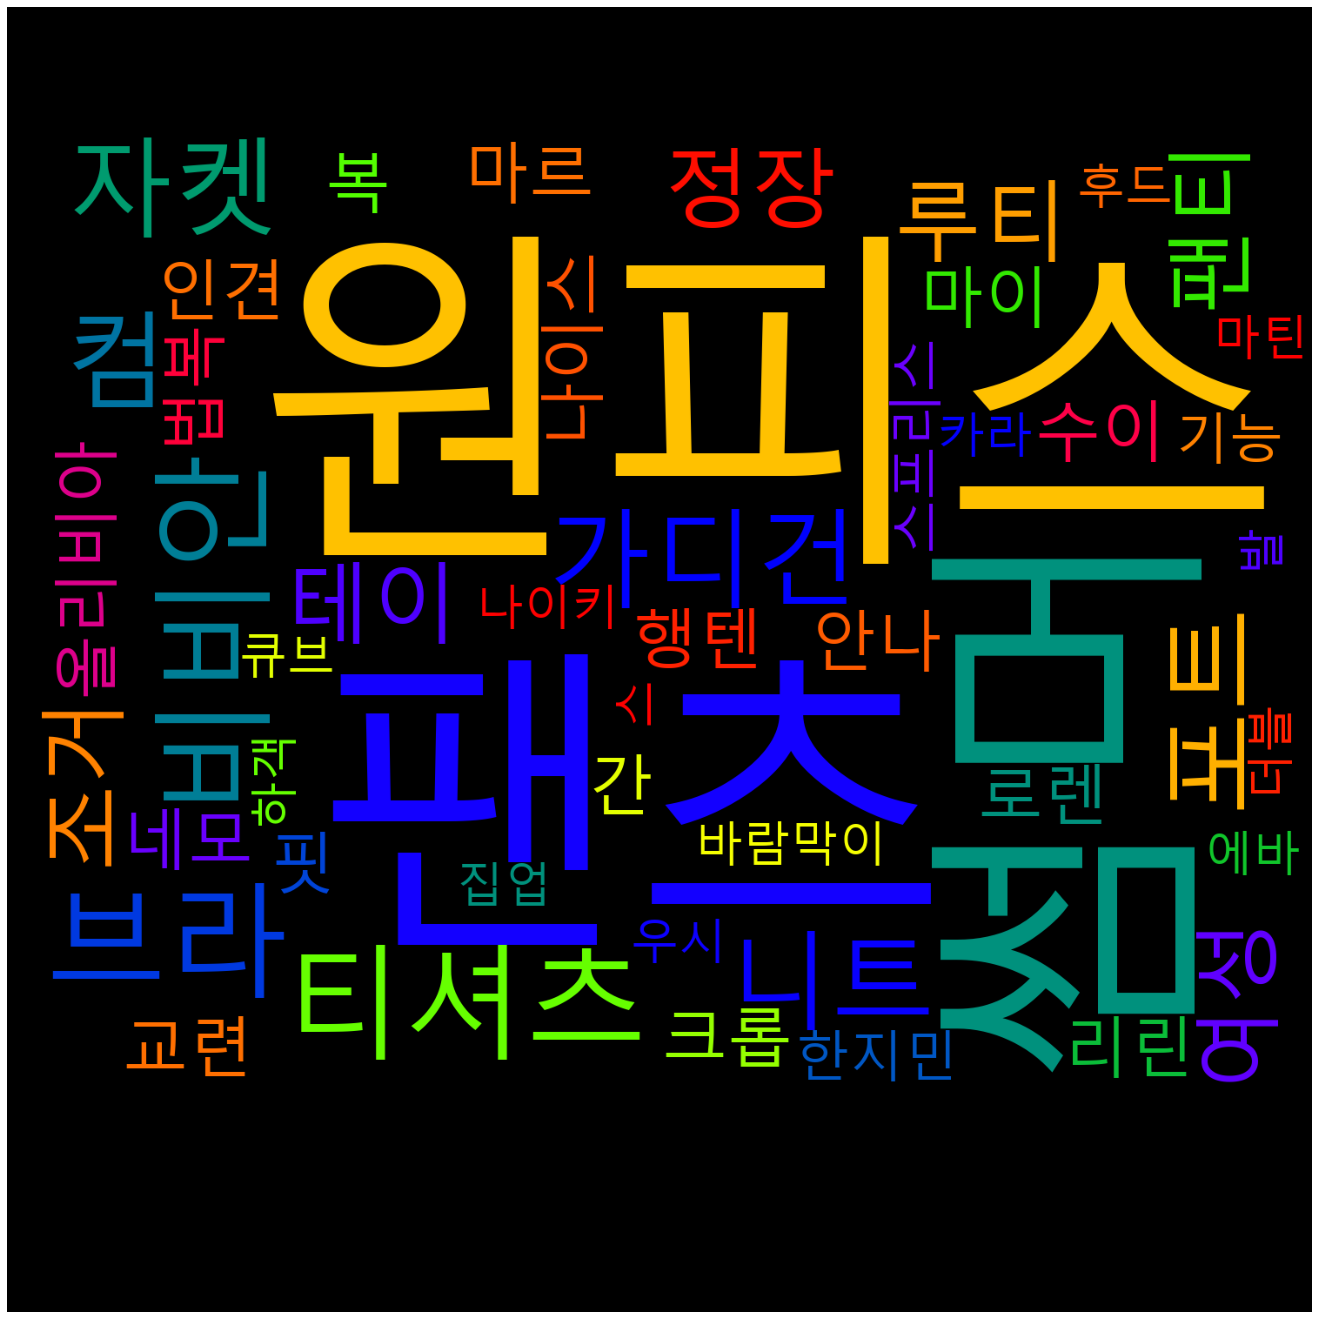

In [198]:
# 자동 띄어쓰기 모듈
from pykospacing import Spacing

In [199]:
spacing = Spacing()

In [200]:
for item in write_keywords:
    kospacing_item = spacing(item)
    print(kospacing_item)

1/1 [==============================] - 1s 537ms/step
교련복
1/1 [==============================] - 0s 24ms/step
마르조 썸머 인 견 팬츠
1/1 [==============================] - 0s 23ms/step
반팔크롭자켓
1/1 [==============================] - 0s 25ms/step
세루티 자켓
1/1 [==============================] - 0s 26ms/step
올리비아로 렌티셔츠
1/1 [==============================] - 0s 27ms/step
비비안 마이핏 네모 팬티
1/1 [==============================] - 0s 23ms/step
안나수 이 원피스
1/1 [==============================] - 0s 23ms/step
나이스
1/1 [==============================] - 0s 26ms/step
행텐 10320-150-404-51
1/1 [==============================] - 0s 22ms/step
리린
1/1 [==============================] - 0s 23ms/step
법복
1/1 [==============================] - 0s 27ms/step
모르간 썸머 원피스
1/1 [==============================] - 0s 26ms/step
한지민 가디건
1/1 [==============================] - 0s 23ms/step
스프리스 기능성 바람막이
1/1 [==============================] - 0s 23ms/step
에바큐브
1/1 [==============================] - 0s 32ms/step
여성 정장 하객룩
1/1 [=================

# 트리박스 시각화...출하??

In [103]:
# shapes
"""
1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드들의 최근 1개월간 평균 검색량을 추출한 데이터프레임입니다.
"""
shapes = df_vis.copy()
shapes = shapes.truncate(before=time_month)
shapes = shapes.mean()
shapes = shapes.reset_index()
shapes.columns = ['keyword', 'month_avg_query']
shapes = shapes[:-2]
shapes = shapes.sort_values('month_avg_query', ascending=False).reset_index(drop=True)
shapes.head(20)

C:\Users\User\AppData\Local\Temp\ipykernel_20456\3092077136.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  shapes = shapes.mean()


,keyword,month_avg_query
0,리린,28.500079
1,김건희옷,15.449799
2,나이스,13.570576
3,운동화,13.052885
4,유니클로마르니,8.887810
5,마드제이,2.224100
6,디키즈874여자,1.889672
7,교련복,1.583467
8,폴로반팔셔츠,1.495555
9,셀린느티셔츠,1.452009


<AxesSubplot:title={'center':'최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드'}>

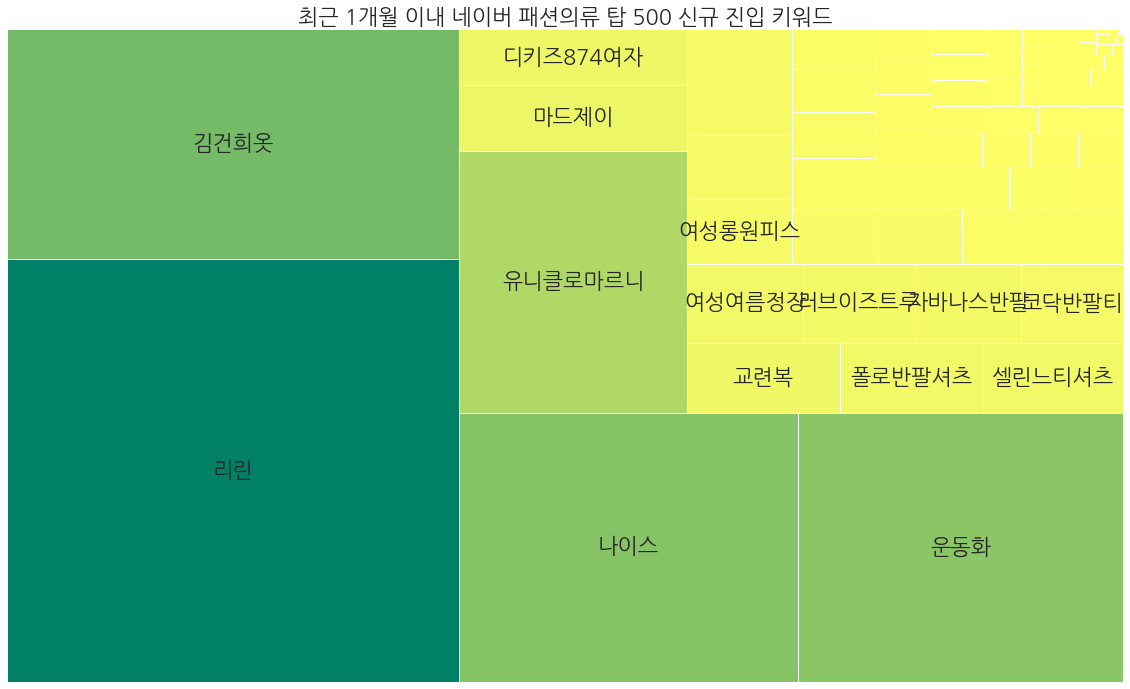

In [107]:
# 색상지도 시각화
cmap = matplotlib.cm.summer_r
norm = matplotlib.colors.Normalize(vmin=shapes.month_avg_query.min(), vmax=shapes.month_avg_query.max())
colors = [cmap(norm(value)) for value in shapes.month_avg_query]

# 연도별 블로그, 카페 건수 트리맵
plt.figure(figsize=(20,12)); plt.axis('off') ; plt.title("최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드")
squarify.plot(
    sizes=shapes.month_avg_query,
    color=colors,
    label=shapes.apply(lambda x: str(x.keyword) if x.month_avg_query >= 1 else '', axis=1),
    alpha=1)
